In [1]:
import numpy as np
from numpy.typing import NDArray

from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation


def sq_cancelled_signal_generator(
    exp_param_factory_set_except_phase: OffAxisFieldExperimentParametersFactory,
    nv_ensemble: HomogeneousEnsemble,
    off_axis_solver: LiouvillianSolver,
) -> NDArray:
    exp_param_factory_set_except_phase.set_second_pulse_phase(0)
    off_axis_experiment_parameters_0_phase = exp_param_factory_set_except_phase.get_experiment_parameters()
    off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters_0_phase, nv_ensemble, off_axis_solver)

    exp_param_factory_set_except_phase.set_second_pulse_phase(np.pi)
    off_axis_experiment_parameters_pi_phase = exp_param_factory_set_except_phase.get_experiment_parameters()
    off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters_pi_phase, nv_ensemble, off_axis_solver)

    return off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

In [ ]:
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_paper_figures.inner_product_functions import double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    fit_vs_eigenvalue_error_nT,
    extract_fit_centers,
)
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues


def double_cosine_inner_product_fit_inversion(
    sq_cancelled_signal,
    off_axis_experiment_parameters,
    inner_product_settings,
    ramsey_freq_range_initial_guess_hz,
    t2star_s,
    constrain_same_width=True,
):
    rabi_frequencies = get_bare_rabi_frequencies(off_axis_experiment_parameters)
    larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(off_axis_experiment_parameters)

    errors_nT = []
    for i, orientation in enumerate(NVOrientation):
        cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
            sq_cancelled_signal,
            rabi_frequencies[orientation],
            ramsey_freq_range_initial_guess_hz,
            inner_product_settings,
        )
        first_attempt_peaks = extract_fit_centers(
            fit_constrained_hyperfine_peaks(ramsey_freq_range_initial_guess_hz, cos_cos_inner_prod, t2star_s)
        )

        expected_fwhm_hz = 2 / (np.pi * t2star_s)
        min_ramsey_freq_hz = max(expected_fwhm_hz, min(first_attempt_peaks) - expected_fwhm_hz)
        max_ramsey_freq_hz = max(first_attempt_peaks) + expected_fwhm_hz
        ramsey_freq_range_constrained_hz = np.linspace(
            min_ramsey_freq_hz, max_ramsey_freq_hz, len(ramsey_freq_range_initial_guess_hz)
        )

        cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
            sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freq_range_constrained_hz, inner_product_settings
        )
        fit_result = fit_constrained_hyperfine_peaks(
            ramsey_freq_range_constrained_hz, cos_cos_inner_prod, t2star_s, constrain_same_width=constrain_same_width
        )

        errors_nT.append(fit_vs_eigenvalue_error_nT(fit_result, larmor_freqs_all_axes_hz[orientation]))

    return np.array(errors_nT)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.constants import exy, NVaxes_100
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    plot_fit_vs_inner_product,
    fit_vs_eigenvalue_error_nT,
    extract_fit_centers,
)
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues

T_TO_UT = 1e6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [20e-6 / np.sqrt(21) * x for x in [4, 2, 1]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 500e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 201
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

b_field_vector_t = B_FIELD_VECTOR_T

exp_param_factory.set_b_field_vector(b_field_vector_t)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

errors_nT = double_cosine_inner_product_fit_inversion(
    sq_cancelled_signal,
    exp_param_factory.get_experiment_parameters(),
    inner_product_settings,
    RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
    T2STAR_S,
    constrain_same_width=True,
)

print(errors_nT[:, 2])

[ 0.11366852 -1.34833478  0.69192471 -0.42631717]


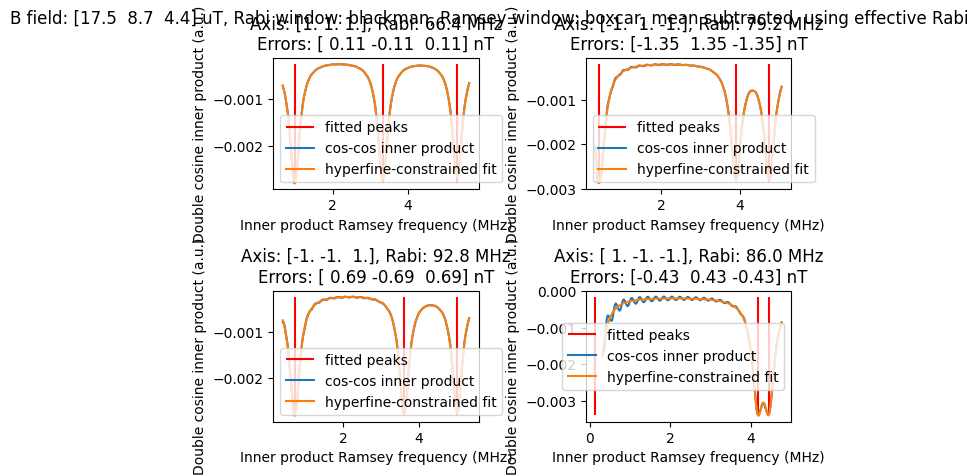

B = [17.5  8.7  4.4] uT, largest eigenvalue errors = [ 0.11 -1.35  0.69 -0.43] nT


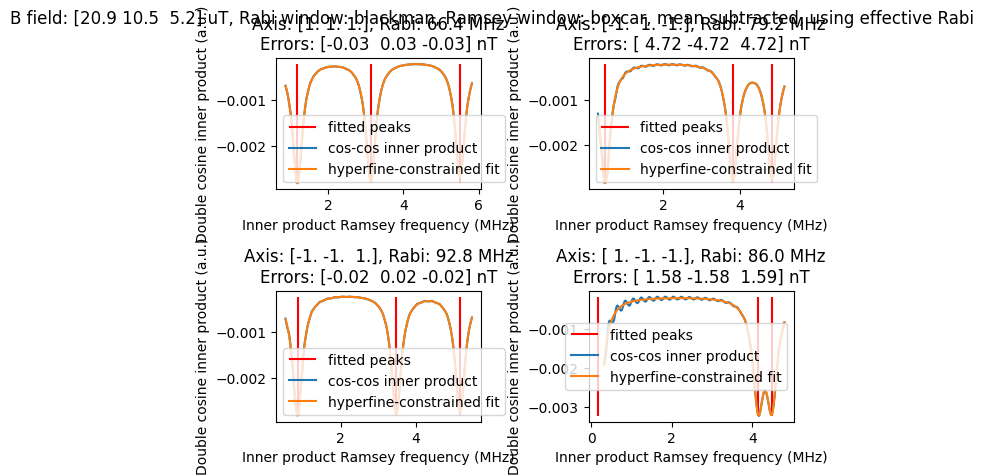

B = [20.9 10.5  5.2] uT, largest eigenvalue errors = [-0.03  4.72 -0.02  1.59] nT


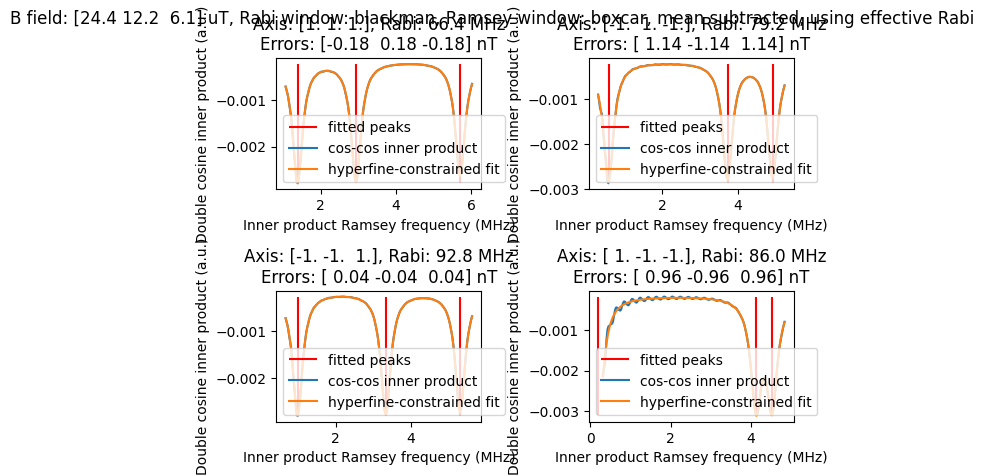

B = [24.4 12.2  6.1] uT, largest eigenvalue errors = [-0.18  1.14  0.04  0.96] nT


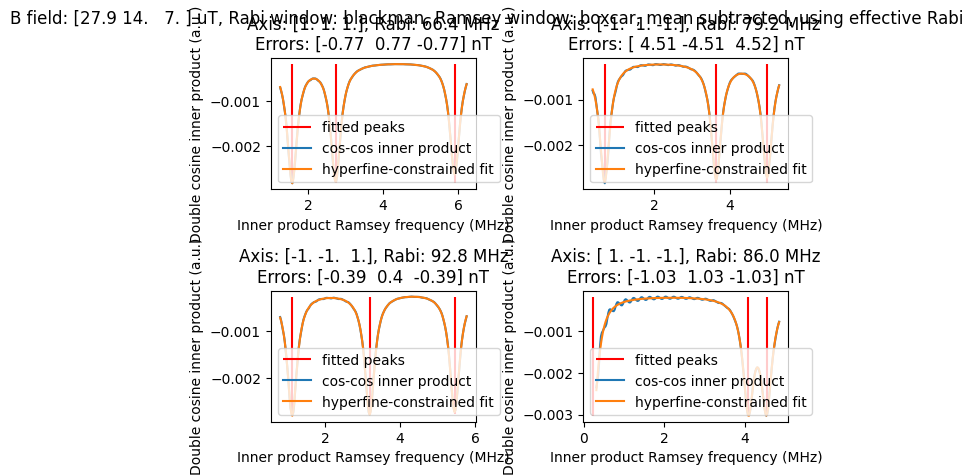

B = [27.9 14.   7. ] uT, largest eigenvalue errors = [-0.77  4.52 -0.39 -1.03] nT


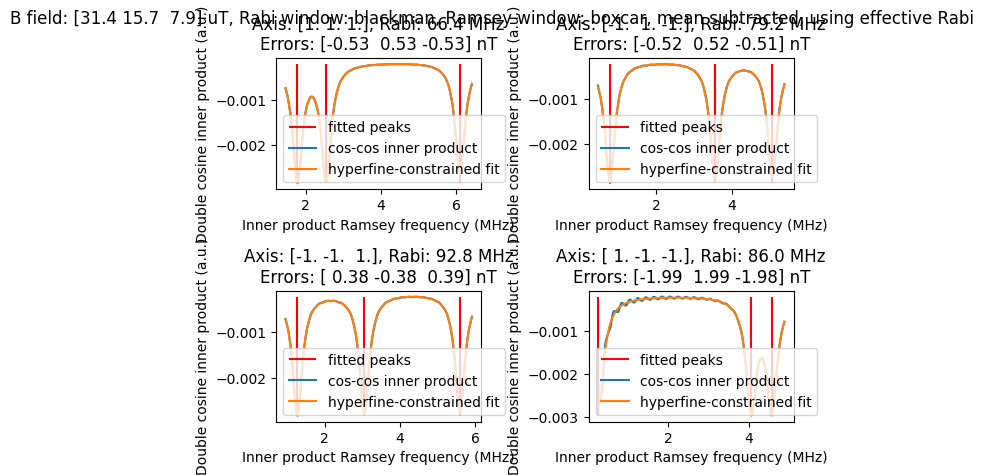

B = [31.4 15.7  7.9] uT, largest eigenvalue errors = [-0.53 -0.51  0.39 -1.98] nT


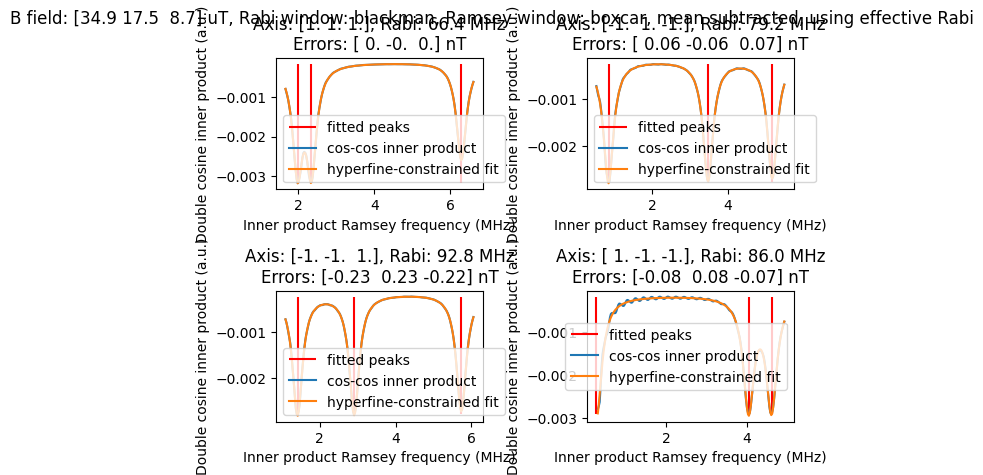

B = [34.9 17.5  8.7] uT, largest eigenvalue errors = [ 0.    0.07 -0.22 -0.07] nT


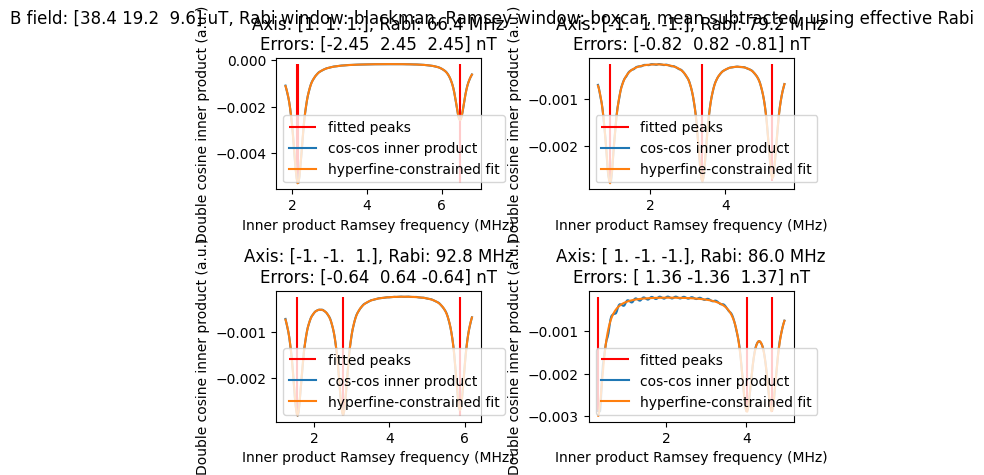

B = [38.4 19.2  9.6] uT, largest eigenvalue errors = [ 2.45 -0.81 -0.64  1.37] nT


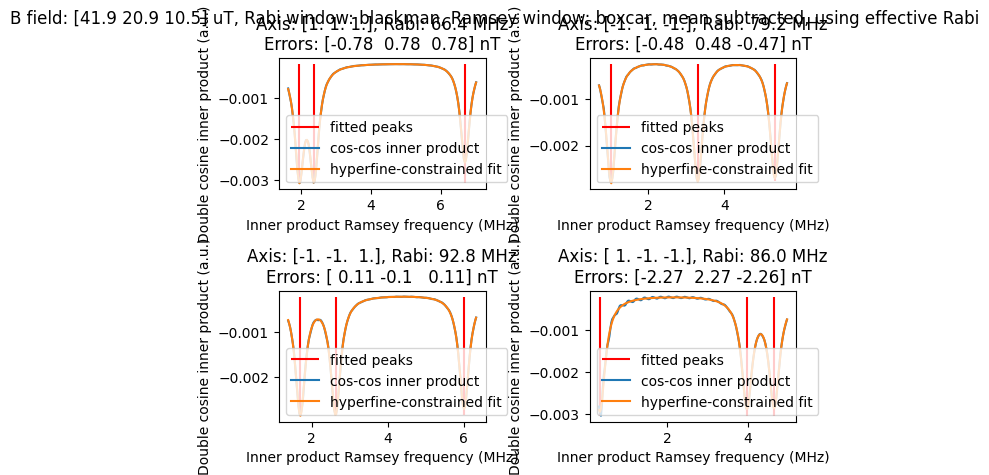

B = [41.9 20.9 10.5] uT, largest eigenvalue errors = [ 0.78 -0.47  0.11 -2.26] nT


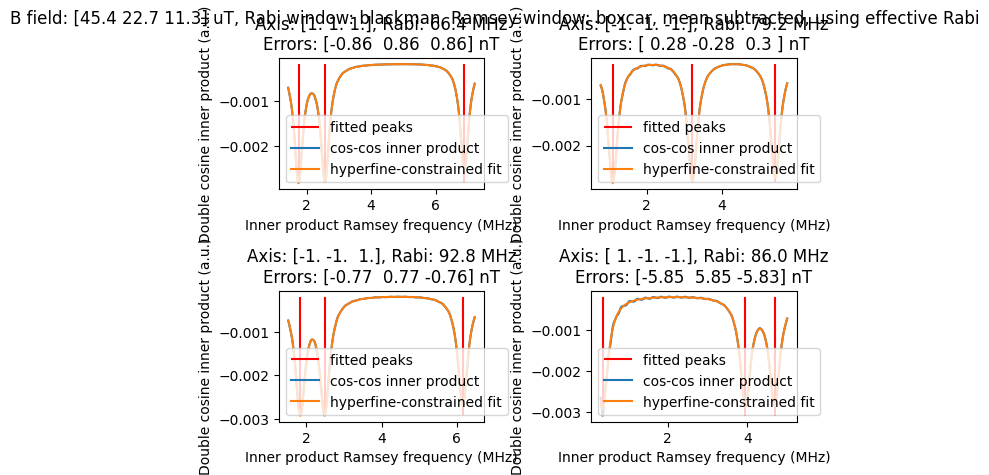

B = [45.4 22.7 11.3] uT, largest eigenvalue errors = [ 0.86  0.3  -0.76 -5.83] nT


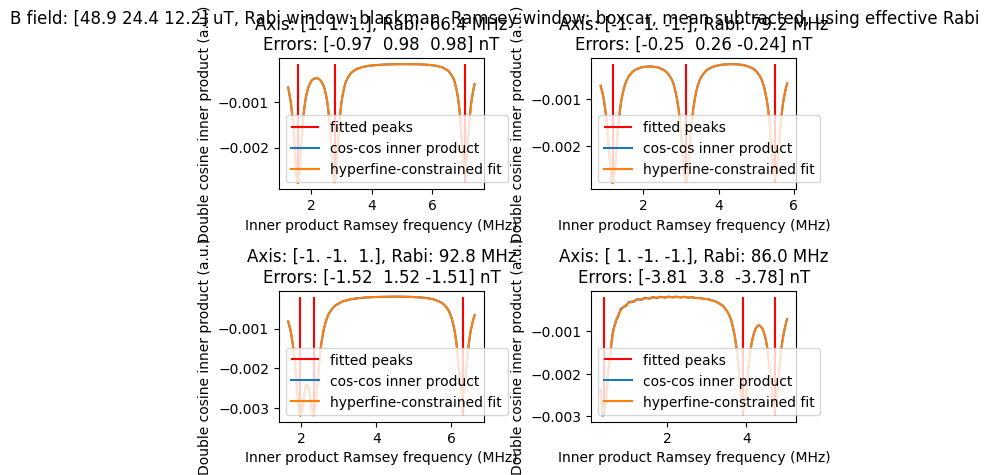

B = [48.9 24.4 12.2] uT, largest eigenvalue errors = [ 0.98 -0.24 -1.51 -3.78] nT


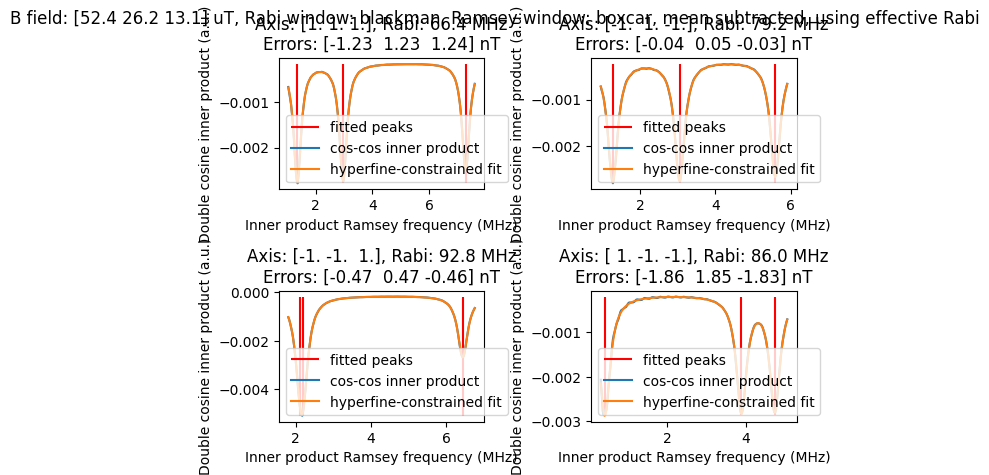

B = [52.4 26.2 13.1] uT, largest eigenvalue errors = [ 1.24 -0.03 -0.46 -1.83] nT


In [13]:
import numpy as np
from matplotlib import pyplot as plt

from bff_simulator.constants import exy
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
)
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [20e-6 / np.sqrt(21) * x for x in [4, 2, 1]]
B_FIELD_VECTOR_DIRECTION = np.array([4, 2, 1])/np.sqrt(21)
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 500e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 201
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
b_magnitudes_t = np.linspace(20e-6, 60e-6, 11) 
b_field_vector_values_t = [mag*B_FIELD_VECTOR_DIRECTION for mag in b_magnitudes_t]
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

errors_vs_b_nT = []
for b_field_vector_t in b_field_vector_values_t:
    exp_param_factory.set_b_field_vector(b_field_vector_t)
    sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

    errors_nT = double_cosine_inner_product_fit_inversion_with_plot(
        sq_cancelled_signal,
        exp_param_factory.get_experiment_parameters(),
        inner_product_settings,
        RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
        T2STAR_S,
        constrain_same_width=True,
    )
    plt.suptitle(
        f"B field: {np.array2string(T_TO_UT * np.array(b_field_vector_t), precision=1)} uT, Rabi window: {inner_product_settings.rabi_window}, Ramsey window: {inner_product_settings.ramsey_window}, {'mean subtracted' if inner_product_settings.subtract_mean else ''}, {'using effective Rabi' if inner_product_settings.use_effective_rabi_frequency else ''}"
    )
    plt.show()

    print(f"B = {np.array2string(T_TO_UT*b_field_vector_t, precision=1)} uT, largest eigenvalue errors = {np.array2string(errors_nT[:, 2], precision=2)} nT")
    errors_vs_b_nT.append(errors_nT[:, 2])

In [7]:
np.array(errors_vs_b_nT)[:,0]

array([ 0.11366852, -0.02619346, -0.18353695, -0.76589408, -0.53272031,
        0.00328661,  2.45399901,  0.77997502,  0.86211137,  0.9787541 ,
        1.23552518])

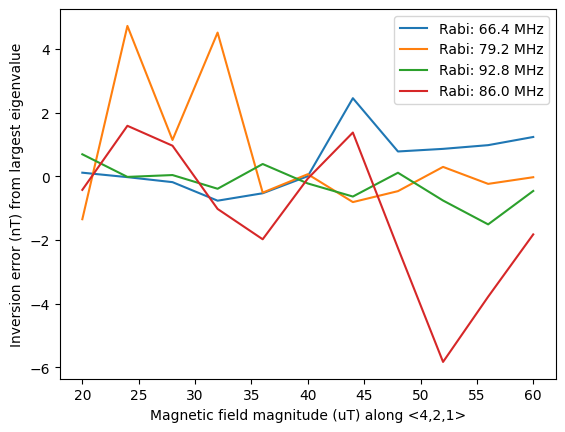

In [ ]:
for orientation in NVOrientation:
    plt.plot(T_TO_UT*b_magnitudes_t, np.array(errors_vs_b_nT)[:,orientation], label=f"Rabi: {HZ_TO_MHZ*rabi_frequencies[orientation]:.1f} MHz")
plt.xlabel("Magnetic field magnitude (uT) along <4,2,1>")
plt.ylabel("Inversion error (nT) from largest eigenvalue")
plt.legend()

## Vs B field angle

In [ ]:
import numpy as np
from numpy.typing import NDArray

from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import (
    OffAxisFieldExperimentParametersFactory,
    OffAxisFieldExperimentParameters,
)
from bff_simulator.simulator import Simulation
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_paper_figures.inner_product_functions import double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    fit_vs_eigenvalue_error_nT,
    extract_fit_centers,
    plot_fit_vs_inner_product
)
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.inner_product_functions import InnerProductSettings

def double_cosine_inner_product_fit_inversion_with_plot(
    sq_cancelled_signal: NDArray,
    off_axis_experiment_parameters: OffAxisFieldExperimentParameters,
    inner_product_settings: InnerProductSettings,
    ramsey_freq_range_init_guess_hz: NDArray,
    t2star_s: float,
    constrain_same_width: bool = True,
    allow_zero_peak:bool = True,
) -> NDArray:
    rabi_frequencies = get_bare_rabi_frequencies(off_axis_experiment_parameters)
    larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(off_axis_experiment_parameters)

    errors_nT = []
    for i, orientation in enumerate(NVOrientation):

        plt.subplot(2, 2, i + 1)
        cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
            sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freq_range_init_guess_hz, inner_product_settings
        )
        first_attempt_peaks = extract_fit_centers(
            fit_constrained_hyperfine_peaks(ramsey_freq_range_init_guess_hz, cos_cos_inner_prod, t2star_s,constrain_same_width=constrain_same_width, allow_zero_peak=allow_zero_peak)
        )

        expected_fwhm_hz = 2 / (np.pi * t2star_s)
        min_ramsey_freq_hz = max(expected_fwhm_hz, min(first_attempt_peaks) - expected_fwhm_hz)
        max_ramsey_freq_hz = max(first_attempt_peaks) + expected_fwhm_hz
        ramsey_freq_range_constrained_hz = np.linspace(
            min_ramsey_freq_hz, max_ramsey_freq_hz, len(ramsey_freq_range_init_guess_hz)
        )

        cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
            sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freq_range_constrained_hz, inner_product_settings
        )
        fit_result = fit_constrained_hyperfine_peaks(
            ramsey_freq_range_constrained_hz, cos_cos_inner_prod, t2star_s, constrain_same_width=constrain_same_width
        )

        plot_fit_vs_inner_product(ramsey_freq_range_constrained_hz, cos_cos_inner_prod, fit_result)
        error_nT = fit_vs_eigenvalue_error_nT(fit_result, larmor_freqs_all_axes_hz[orientation])
        plt.title(
                f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[orientation], precision=0)}, Rabi: {rabi_frequencies[orientation] * 1e-6:.1f} MHz\nErrors: {np.array2string(error_nT, precision=2)} nT"
            )
        errors_nT.append(error_nT)

    plt.tight_layout()
    return np.array(errors_nT)

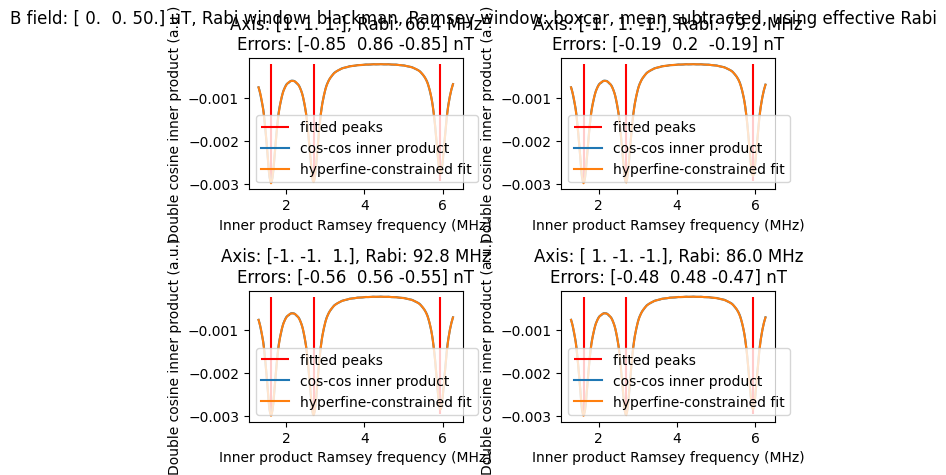

theta = 0.00, phi = 0.00, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.47] nT


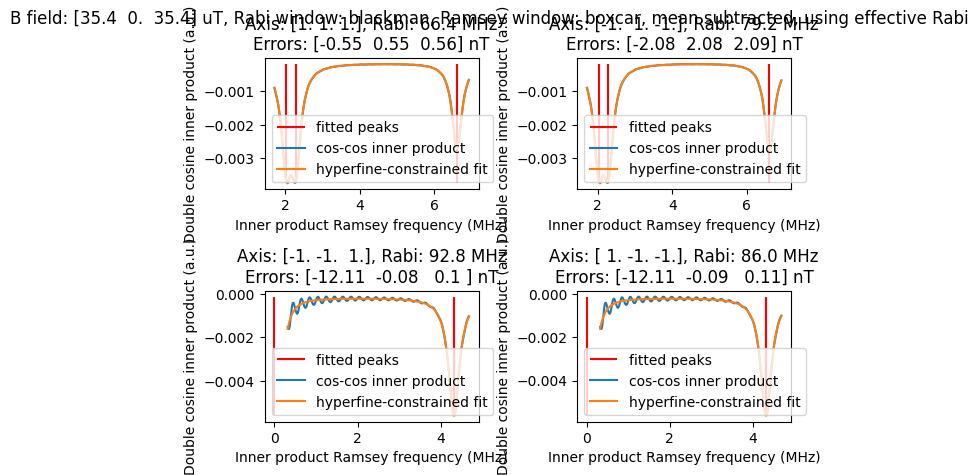

theta = 0.79, phi = 0.00, largest eigenvalue errors = [0.56 2.09 0.1  0.11] nT


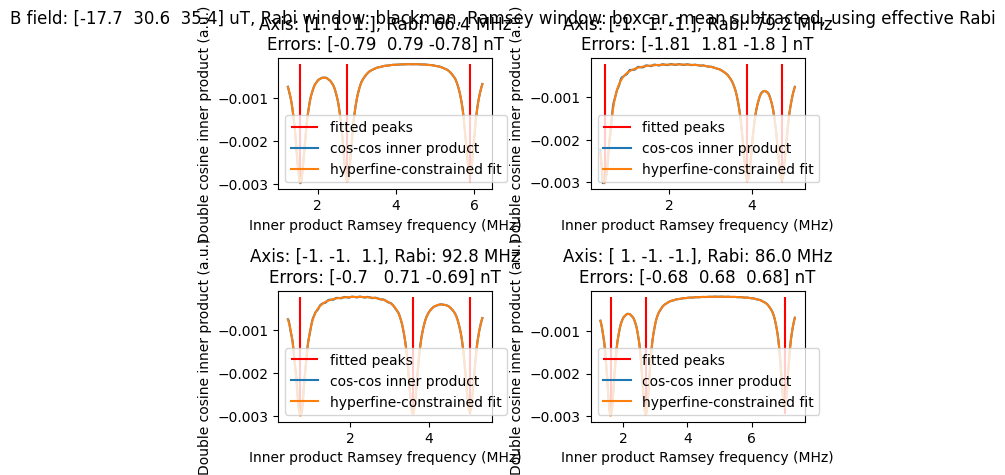

theta = 0.79, phi = 2.09, largest eigenvalue errors = [-0.78 -1.8  -0.69  0.68] nT


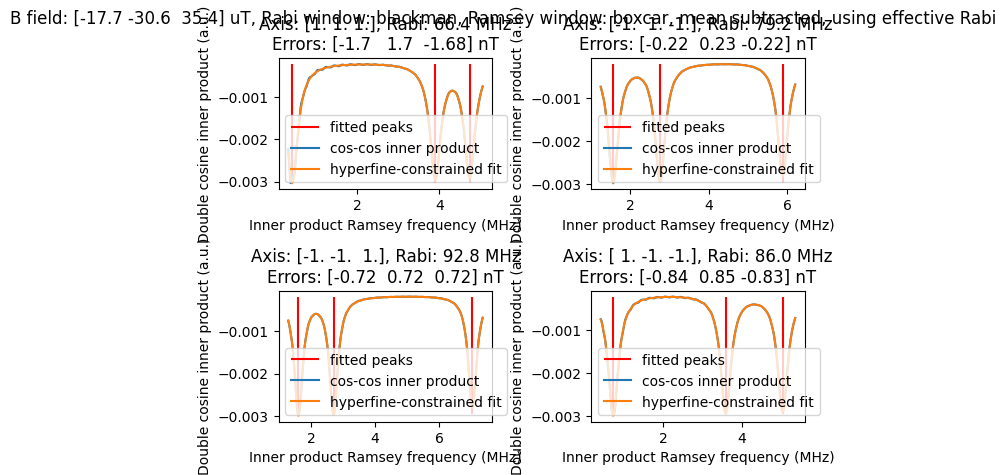

theta = 0.79, phi = 4.19, largest eigenvalue errors = [-1.68 -0.22  0.72 -0.83] nT
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.


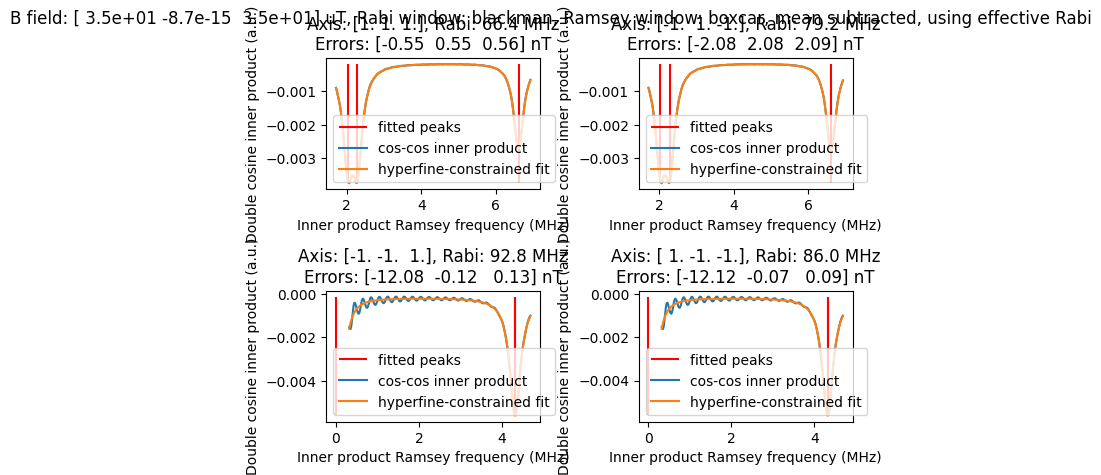

theta = 0.79, phi = 6.28, largest eigenvalue errors = [0.56 2.09 0.13 0.09] nT


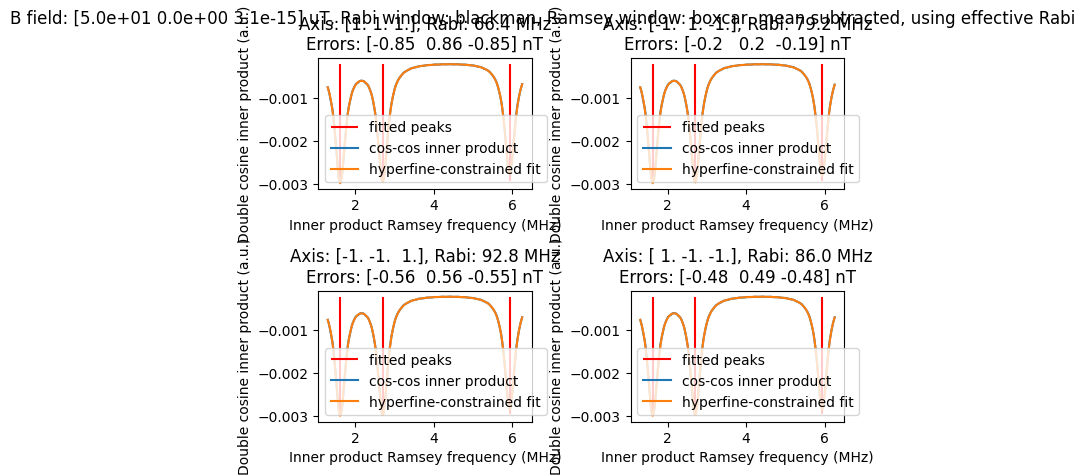

theta = 1.57, phi = 0.00, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.48] nT


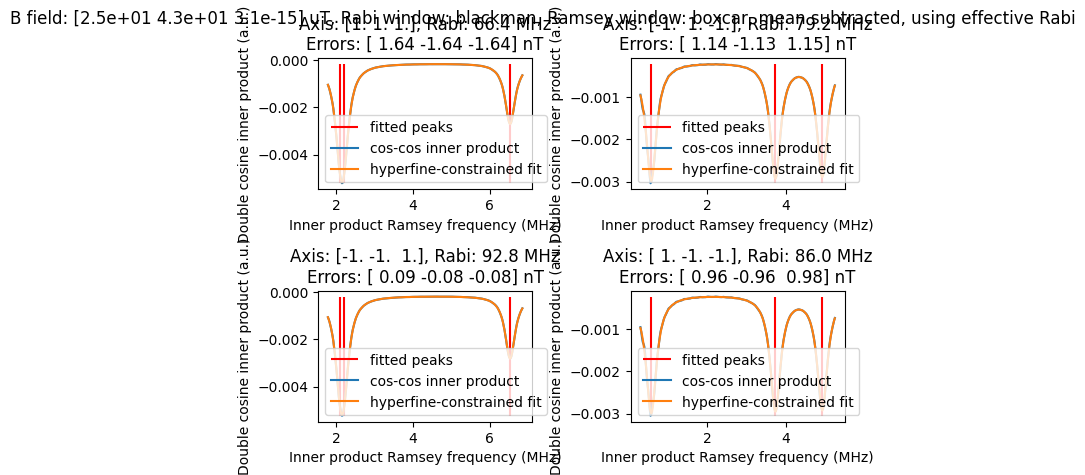

theta = 1.57, phi = 1.05, largest eigenvalue errors = [-1.64  1.15 -0.08  0.98] nT


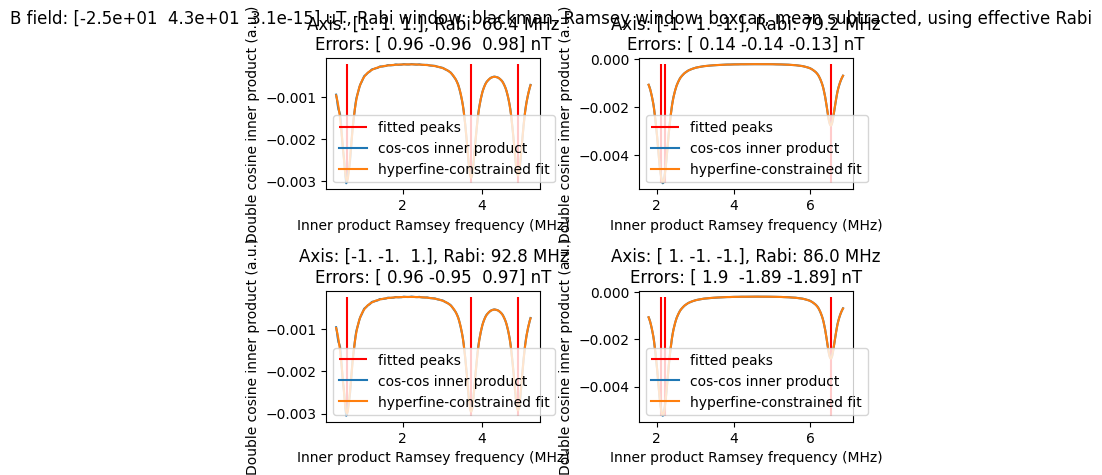

theta = 1.57, phi = 2.09, largest eigenvalue errors = [ 0.98 -0.13  0.97 -1.89] nT


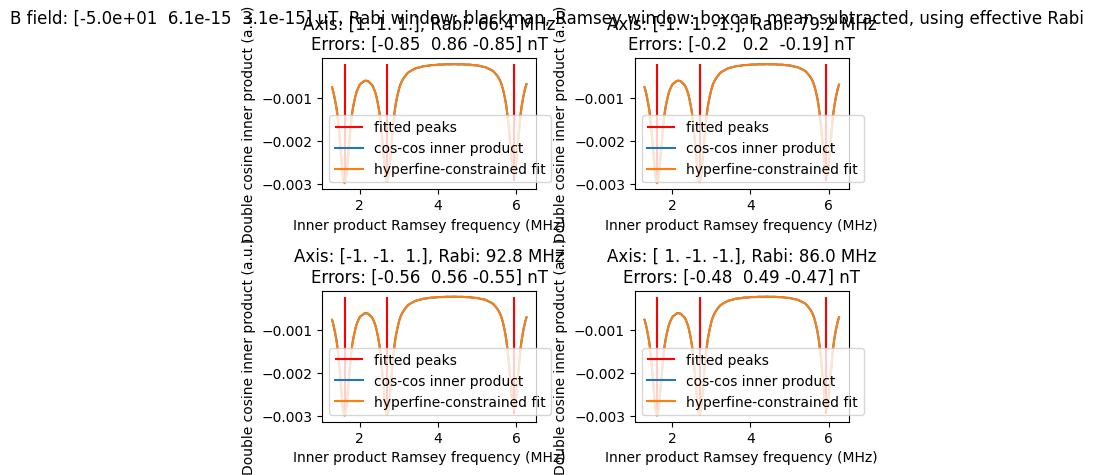

theta = 1.57, phi = 3.14, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.47] nT


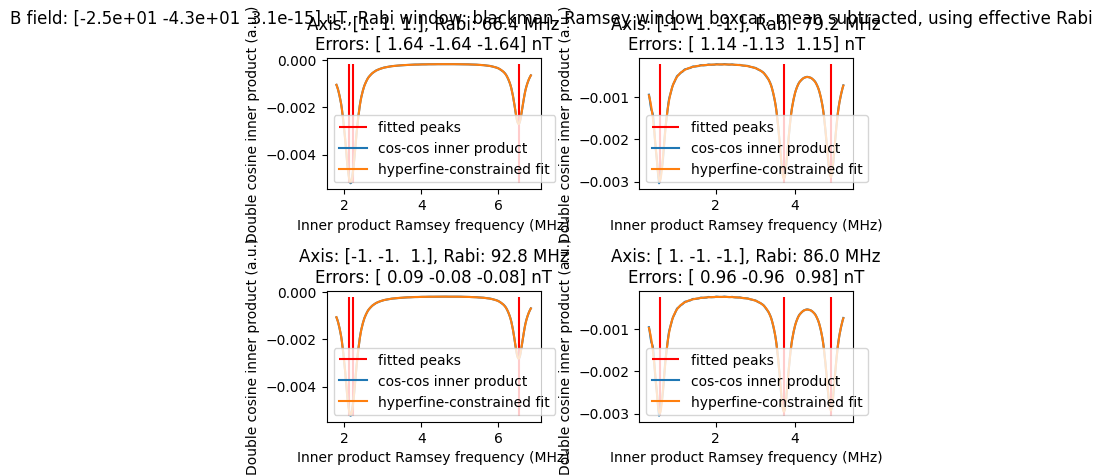

theta = 1.57, phi = 4.19, largest eigenvalue errors = [-1.64  1.15 -0.08  0.98] nT


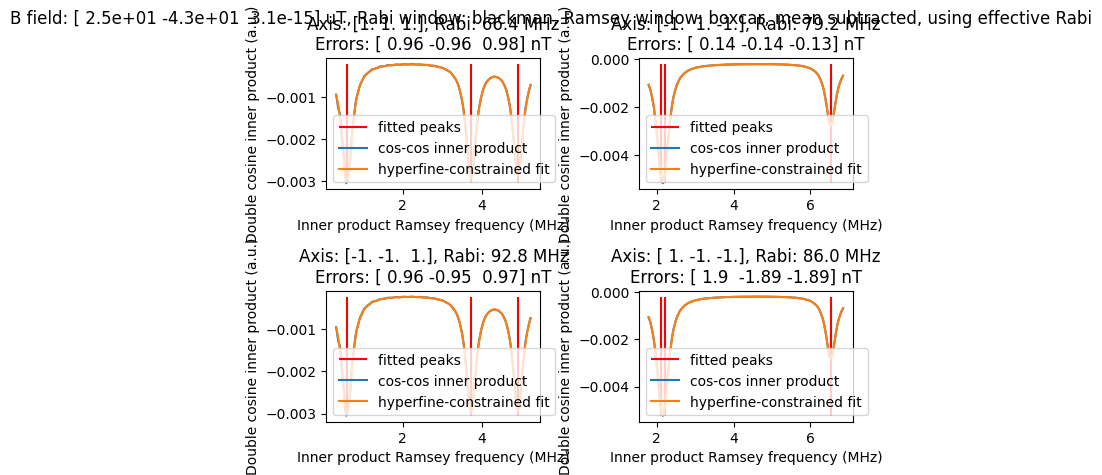

theta = 1.57, phi = 5.24, largest eigenvalue errors = [ 0.98 -0.13  0.97 -1.89] nT


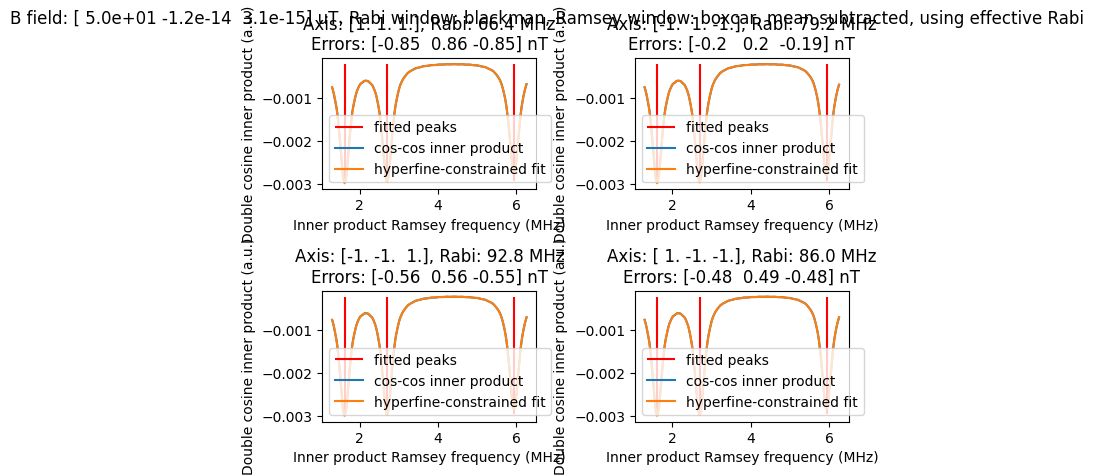

theta = 1.57, phi = 6.28, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.48] nT
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.


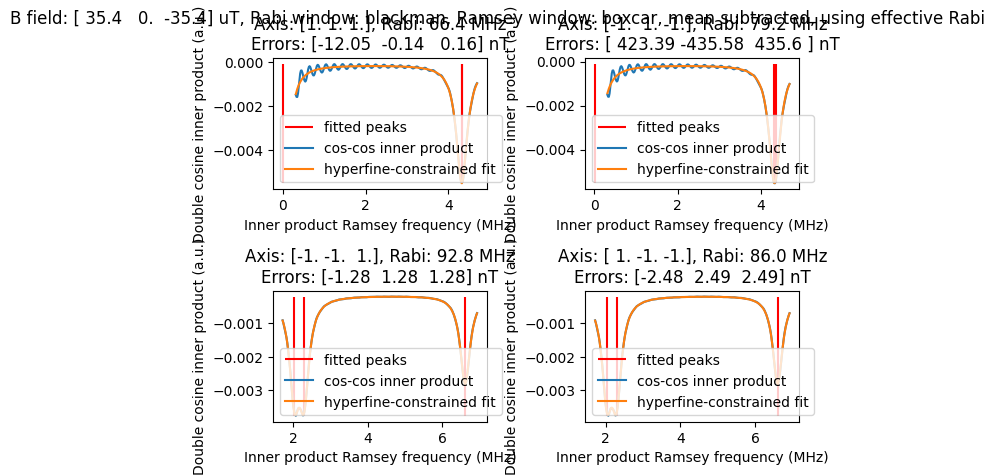

theta = 2.36, phi = 0.00, largest eigenvalue errors = [1.58e-01 4.36e+02 1.28e+00 2.49e+00] nT


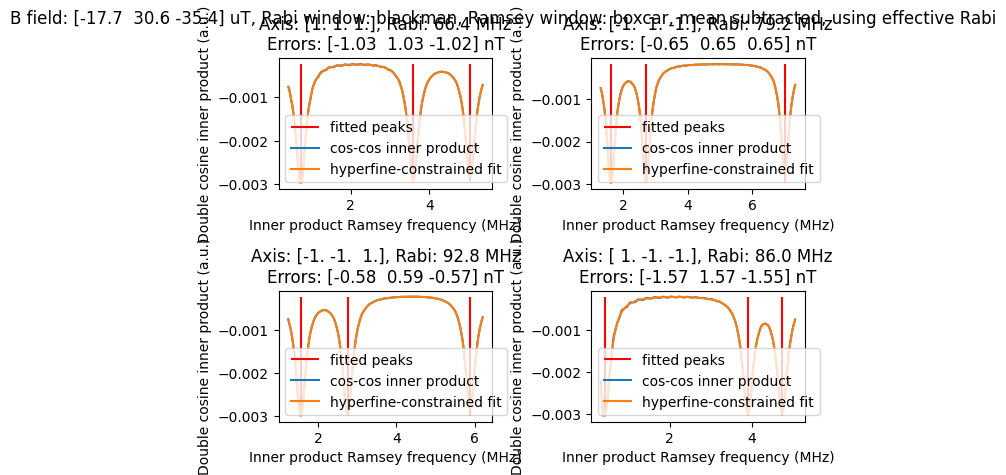

theta = 2.36, phi = 2.09, largest eigenvalue errors = [-1.02  0.65 -0.57 -1.55] nT


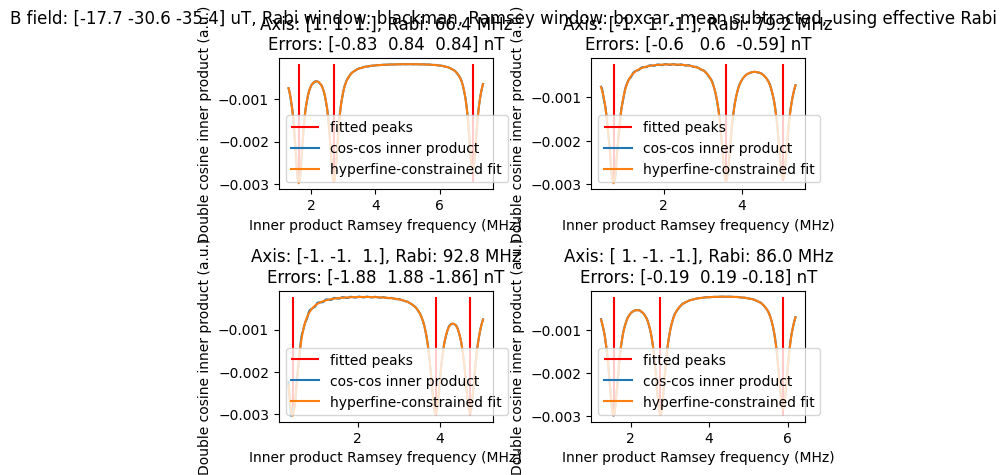

theta = 2.36, phi = 4.19, largest eigenvalue errors = [ 0.84 -0.59 -1.86 -0.18] nT
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.
Poorly-determined order for eigenvectors: ms = +/-1-like order set by numpy.eig output; ms=0-like state assumed recognizable.


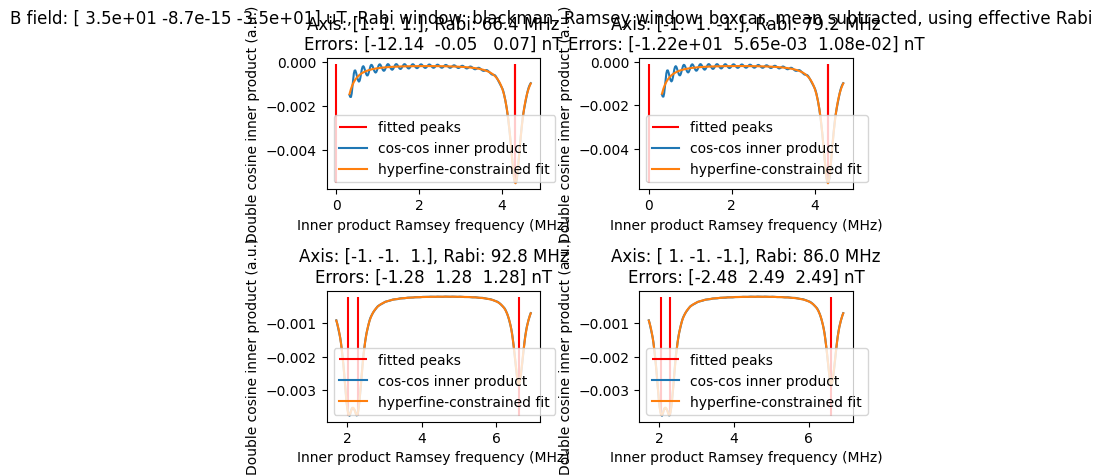

theta = 2.36, phi = 6.28, largest eigenvalue errors = [0.07 0.01 1.28 2.49] nT


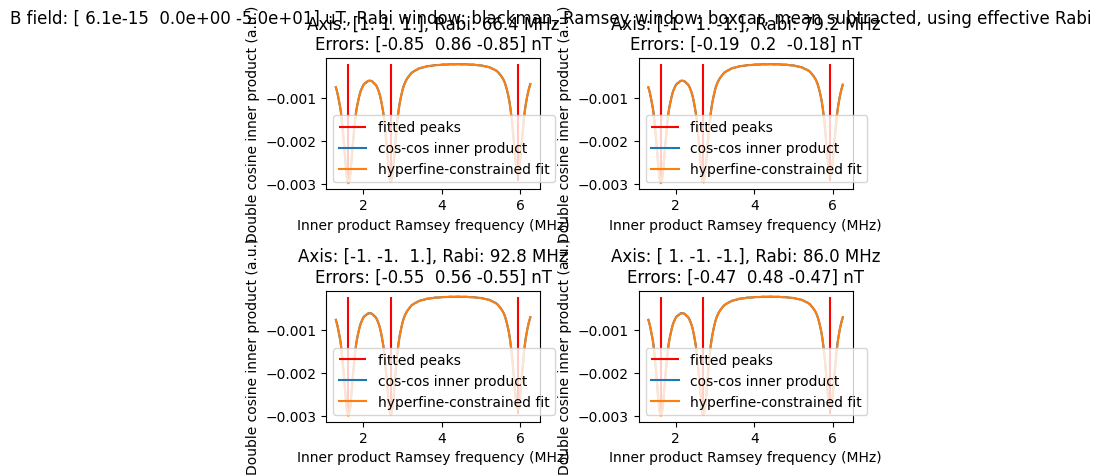

theta = 3.14, phi = 0.00, largest eigenvalue errors = [-0.85 -0.18 -0.55 -0.47] nT


In [16]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt

from bff_simulator.constants import exy, NVaxes_100
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
)
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA_START = 0
B_THETA_STOP = np.pi
B_THETA_N = 5

B_PHI_START = 0
B_PHI_STOP = 2*np.pi
B_PHI_N_MAX = 7

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

theta_values = []
phi_values = []
errors_vs_b_nT = []
for theta in np.linspace(B_THETA_START, B_THETA_STOP, B_THETA_N):
    b_phi_n = max(1, floor(np.sin(theta)*B_PHI_N_MAX))
    for phi in np.linspace(B_PHI_START, B_PHI_STOP, b_phi_n):
        theta_values.append(theta)
        phi_values.append(phi)
        b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        exp_param_factory.set_b_field_vector(b_field_vector_t)
        sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

        errors_nT = double_cosine_inner_product_fit_inversion_with_plot(
            sq_cancelled_signal,
            exp_param_factory.get_experiment_parameters(),
            inner_product_settings,
            RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
            T2STAR_S,
            constrain_same_width=True,
            allow_zero_peak=True,
        )

        plt.suptitle(
            f"B field: {np.array2string(T_TO_UT * np.array(b_field_vector_t), precision=1)} uT, Rabi window: {inner_product_settings.rabi_window}, Ramsey window: {inner_product_settings.ramsey_window}, {'mean subtracted' if inner_product_settings.subtract_mean else ''}, {'using effective Rabi' if inner_product_settings.use_effective_rabi_frequency else ''}"
        )
        plt.show()

        print(f"theta = {theta:.2f}, phi = {phi:.2f}, largest eigenvalue errors = {np.array2string(errors_nT[:, 2], precision=2)} nT")
        errors_vs_b_nT.append(errors_nT[:, 2])

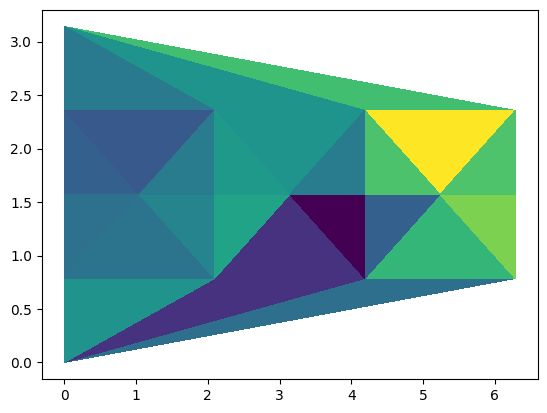

In [28]:
plt.tripcolor(phi_values, theta_values, np.array(errors_vs_b_nT)[:,0])

In [27]:
np.array(errors_vs_b_nT)[:,0]

array([-0.84502066,  0.55564901, -0.78235081, -1.6831912 ,  0.55565199,
       -0.84714681, -1.63805257,  0.97501821, -0.84723208, -1.63824006,
        0.97501237, -0.84714679,  0.15775396, -1.01821485,  0.8360227 ,
        0.06987356, -0.84507728])

In [ ]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt

from bff_simulator.constants import exy, NVaxes_100
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
)
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA_START = 0
B_THETA_STOP = np.pi
B_THETA_N = 21

B_PHI_START = 0
B_PHI_STOP = 2*np.pi
B_PHI_N_MAX = 42

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

theta_values = []
phi_values = []
errors_vs_b_nT = []
for theta in np.linspace(B_THETA_START, B_THETA_STOP, B_THETA_N):
    b_phi_n = max(3, floor(np.sin(theta)*B_PHI_N_MAX))
    for phi in np.linspace(B_PHI_START, B_PHI_STOP, b_phi_n):
        theta_values.append(theta)
        phi_values.append(phi)
        b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        exp_param_factory.set_b_field_vector(b_field_vector_t)
        sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

        larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

        fit_results = double_cosine_inner_product_fit_inversion(
            sq_cancelled_signal,
            exp_param_factory.get_experiment_parameters(),
            inner_product_settings,
            RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
            T2STAR_S,
            constrain_same_width=True,
            allow_zero_peak=True,
        )
        errors_nT = fit_vs_eigenvalue_error_all_orientations_nT(fit_results, larmor_freqs_all_axes_hz)

        print(f"theta = {theta:.2f}, phi = {phi:.2f}, largest eigenvalue errors = {np.array2string(errors_nT[:, 0], precision=2)} nT")
        errors_vs_b_nT.append(errors_nT[:, 0])

theta = 0.00, phi = 0.00, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.47] nT
theta = 0.00, phi = 3.14, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.47] nT
theta = 0.00, phi = 6.28, largest eigenvalue errors = [-0.85 -0.19 -0.55 -0.47] nT
theta = 0.16, phi = 0.00, largest eigenvalue errors = [-1.03 -0.48 -0.82  0.04] nT
theta = 0.16, phi = 1.26, largest eigenvalue errors = [ 0.2  -0.54  0.44  0.31] nT
theta = 0.16, phi = 2.51, largest eigenvalue errors = [-0.15 -0.39 -0.67 -0.31] nT
theta = 0.16, phi = 3.77, largest eigenvalue errors = [-0.71 -0.53 -0.42 -0.41] nT
theta = 0.16, phi = 5.03, largest eigenvalue errors = [-0.89  0.73 -0.6   0.96] nT
theta = 0.16, phi = 6.28, largest eigenvalue errors = [-1.03 -0.48 -0.82  0.04] nT
theta = 0.31, phi = 0.00, largest eigenvalue errors = [-0.6  -1.78 -0.48  0.03] nT
theta = 0.31, phi = 0.57, largest eigenvalue errors = [-1.82  0.32  0.36 -0.04] nT
theta = 0.31, phi = 1.14, largest eigenvalue errors = [0.15 0.8  1.38 0.48] nT
theta = 

In [37]:
np.savetxt("errors_vs_b_nt.txt", errors_vs_b_nT)
np.savetxt("phi_values.txt", phi_values)
np.savetxt("theta_values.txt", theta_values)

In [56]:
errors_vs_b_nT=np.loadtxt("errors_vs_b_nt.txt")
phi_values=np.loadtxt("phi_values.txt")
theta_values=np.loadtxt("theta_values.txt")

errors_vs_b_nT_fine=np.loadtxt("errors_nt_b_50_ut_t2s_2.000000_us.txt")
phi_values_fine=np.loadtxt("phi_values_b_50_ut_t2s_2.000000_us.txt")
theta_values_fine=np.loadtxt("theta_values_b_50_ut_t2s_2.000000_us.txt")

errors_vs_b_nT_fine2=np.loadtxt("errors_nt_b_50_ut_t2s_2.000000_us_interleaved.txt")
phi_values_fine2=np.loadtxt("phi_values_b_50_ut_t2s_2.000000_us_interleaved.txt")
theta_values_fine2=np.loadtxt("theta_values_b_50_ut_t2s_2.000000_us_interleaved.txt")



In [57]:
errors_vs_b_nT_total=np.concatenate((errors_vs_b_nT, errors_vs_b_nT_fine,errors_vs_b_nT_fine2))
phi_values_total = np.concatenate((phi_values, phi_values_fine,phi_values_fine2))
theta_values_total = np.concatenate((theta_values, theta_values_fine,theta_values_fine2))

[[ 0.50392324  1.15491069 -0.06215208 -0.70798222]
 [-0.3904043   2.80099344  0.79832645  0.14301995]
 [-1.03532936 -0.48828965 -0.82878201  0.02809974]
 ...
 [-0.2250011   0.19028461 -0.17480441  0.46589708]
 [-0.18265923 -0.23592125 -1.56029708  0.20642914]
 [ 0.37564409 -0.93853875 -0.58697787  0.58022425]]


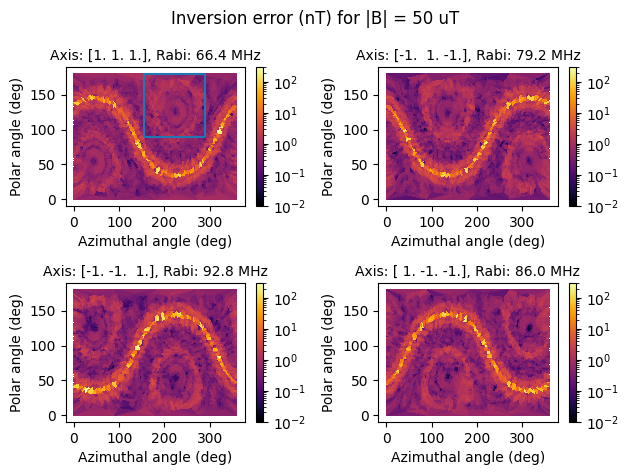

In [ ]:
for i,orientation in enumerate(NVOrientation):
    plt.subplot(2,2,i+1)
    plt.tripcolor(np.array(phi_values_total)*360/(2*np.pi), np.array(theta_values_total)*360/(2*np.pi), np.abs(np.array(errors_vs_b_nT_total)[:,orientation]),cmap="inferno", norm="log", vmin=.01, vmax=300)
    plt.colorbar()
    plt.xlabel("Azimuthal angle (deg)")
    plt.ylabel("Polar angle (deg)")
    plt.title(
        f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[orientation], precision=0)}, Rabi: {rabi_frequencies[orientation] * 1e-6:.1f} MHz", fontsize=10
    )
    if i==0:
        plt.vlines([155, 290], [90], [180])
        plt.hlines([90, 180],[155], [290])
plt.suptitle("Inversion error (nT) for |B| = 50 uT")
plt.tight_layout()

In [62]:
masks = np.array([theta_values_total*360/(2*np.pi) > 90, theta_values_total*360/(2*np.pi) < 180, phi_values_total*360/(2*np.pi) < 290,phi_values_total*360/(2*np.pi) > 155])
mask = np.all(masks, axis=0)
phi_values_masked = phi_values_total[mask]
theta_values_masked = theta_values_total[mask]
errors_vs_b_nT_masked = errors_vs_b_nT_total[mask]
np.sqrt(np.mean(errors_vs_b_nT_masked[:,0]**2))

np.float64(0.9861804042481177)

In [64]:
masks = np.array([theta_values_total*360/(2*np.pi) < 90, theta_values_total*360/(2*np.pi) > 0, phi_values_total*360/(2*np.pi) < 290,phi_values_total*360/(2*np.pi) > 155])
mask = np.all(masks, axis=0)
phi_values_masked = phi_values_total[mask]
theta_values_masked = theta_values_total[mask]
errors_vs_b_nT_masked = errors_vs_b_nT_total[mask]
np.sqrt(np.mean(errors_vs_b_nT_masked[:,2]**2))

np.float64(1.1024573556314332)

## Generating figure 4 components

/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_41595/2479660504.py:13: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad = np.array([fsolve(half_hyperfine, [2.5], (phi))[0] for phi in phi_range_rad])
/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_41595/2479660504.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad_low = np.array([fsolve(half_hyperfine, [1.5], (phi))[0] for phi in phi_range_rad])


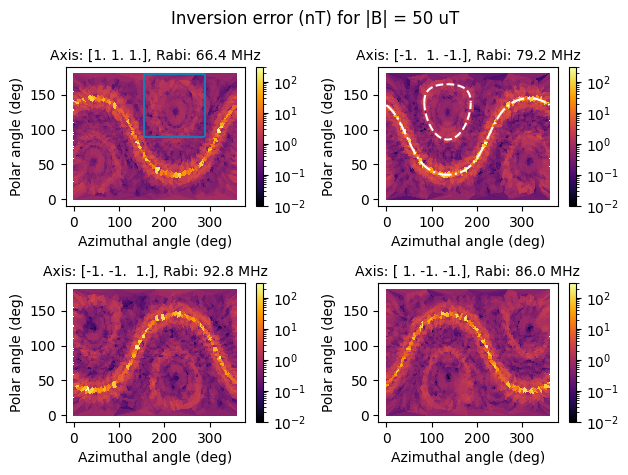

In [21]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import fsolve
from bff_simulator.constants import f_h, gammab
B_MAGNITUDE_T = 50e-6
RAD_TO_DEGREE = 360/(2*np.pi)
phi_range_rad = np.linspace(1.4607, 3.25133, 301)

def half_hyperfine(theta, phi):
    return (-np.cos(theta)-np.cos(phi)*np.sin(theta) + np.sin(theta)*np.sin(phi))/np.sqrt(3) - f_h/(2*B_MAGNITUDE_T*gammab)

theta_hh_rad = np.array([fsolve(half_hyperfine, [2.5], (phi))[0] for phi in phi_range_rad])
theta_hh_rad_low = np.array([fsolve(half_hyperfine, [1.5], (phi))[0] for phi in phi_range_rad])

errors_vs_b_nT=np.loadtxt("errors_vs_b_nt.txt")
phi_values=np.loadtxt("phi_values.txt")
theta_values=np.loadtxt("theta_values.txt")

errors_vs_b_nT_fine=np.loadtxt("errors_nt_b_50_ut_t2s_2.000000_us.txt")
phi_values_fine=np.loadtxt("phi_values_b_50_ut_t2s_2.000000_us.txt")
theta_values_fine=np.loadtxt("theta_values_b_50_ut_t2s_2.000000_us.txt")

errors_vs_b_nT_fine2=np.loadtxt("errors_nt_b_50_ut_t2s_2.000000_us_interleaved.txt")
phi_values_fine2=np.loadtxt("phi_values_b_50_ut_t2s_2.000000_us_interleaved.txt")
theta_values_fine2=np.loadtxt("theta_values_b_50_ut_t2s_2.000000_us_interleaved.txt")

errors_vs_b_nT_total=np.concatenate((errors_vs_b_nT, errors_vs_b_nT_fine,errors_vs_b_nT_fine2))
phi_values_total = np.concatenate((phi_values, phi_values_fine,phi_values_fine2))
theta_values_total = np.concatenate((theta_values, theta_values_fine,theta_values_fine2))

for i,orientation in enumerate(NVOrientation):
    plt.subplot(2,2,i+1)
    plt.tripcolor(np.array(phi_values_total)*RAD_TO_DEGREE, np.array(theta_values_total)*RAD_TO_DEGREE, np.abs(np.array(errors_vs_b_nT_total)[:,orientation]),cmap="inferno", norm="log", vmin=.01, vmax=300)
    plt.colorbar()
    plt.xlabel("Azimuthal angle (deg)")
    plt.ylabel("Polar angle (deg)")
    plt.title(
        f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[orientation], precision=0)}, Rabi: {rabi_frequencies[orientation] * 1e-6:.1f} MHz", fontsize=10
    )
    if i==0:
        plt.vlines([155, 290], [90], [180])
        plt.hlines([90, 180],[155], [290])
    if i==1:
        phi_range_full = np.linspace(0, 2*np.pi, 101)
        theta_no_projection = np.atan2(1, np.sin(phi_range_full) - np.cos(phi_range_full))
        plt.plot(phi_range_full*RAD_TO_DEGREE, theta_no_projection * RAD_TO_DEGREE, color="white", linestyle="dashdot")

        plt.plot(phi_range_rad*RAD_TO_DEGREE, theta_hh_rad*RAD_TO_DEGREE, color="white", linestyle="dashed")
        plt.plot(phi_range_rad*RAD_TO_DEGREE, theta_hh_rad_low*RAD_TO_DEGREE, color="white", linestyle="dashed")

plt.suptitle("Inversion error (nT) for |B| = 50 uT")
plt.tight_layout()
plt.savefig("accuracy50uT.svg")

/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_56316/1993058861.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad = [fsolve(half_hyperfine, [2.5], (phi))[0] for phi in phi_range_rad]
/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_56316/1993058861.py:10: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad_low = [fsolve(half_hyperfine, [1.5], (phi))[0] for phi in phi_range_rad]


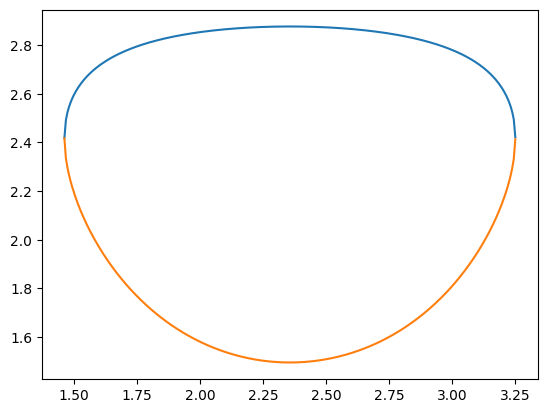

In [251]:
from scipy.optimize import fsolve
from bff_simulator.constants import f_h, gammab
B_MAGNITUDE_T = 50e-6
phi_range_rad = np.linspace(1.4607, 3.25133, 301)

def half_hyperfine(theta, phi):
    return (-np.cos(theta)-np.cos(phi)*np.sin(theta) + np.sin(theta)*np.sin(phi))/np.sqrt(3) - f_h/(2*B_MAGNITUDE_T*gammab)

theta_hh_rad = [fsolve(half_hyperfine, [2.5], (phi))[0] for phi in phi_range_rad]
theta_hh_rad_low = [fsolve(half_hyperfine, [1.5], (phi))[0] for phi in phi_range_rad]
plt.plot(phi_range_rad, theta_hh_rad)
plt.plot(phi_range_rad, theta_hh_rad_low)


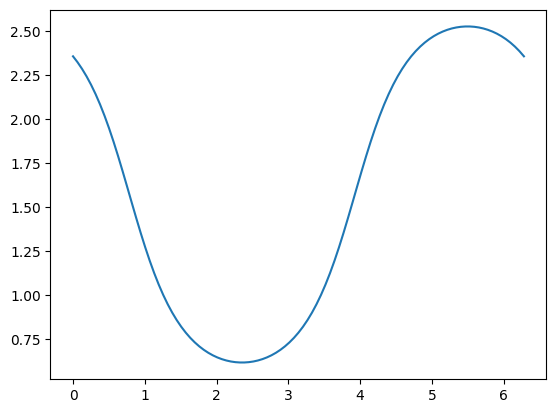

In [198]:
phi_range = np.linspace(0, 2*np.pi, 101)
theta_no_projection = np.atan2(1, np.sin(phi_range) - np.cos(phi_range))
plt.plot(phi_range, theta_no_projection)

In [11]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt

from bff_simulator.constants import exy, NVaxes_100
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
)
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 8.5e6, N_RAMSEY_POINTS)

RUN_LABEL = f"b_{B_MAGNITUDE_T*T_TO_UT:.0f}_ut_t2s_{T2STAR_S*1e6:.0f}_us"

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(B_THETA)*np.cos(B_PHI), np.sin(B_THETA)*np.sin(B_PHI), np.cos(B_THETA)])
exp_param_factory.set_b_field_vector(b_field_vector_t)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)


larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

fit_results = double_cosine_inner_product_fit_inversion(
    sq_cancelled_signal,
    exp_param_factory.get_experiment_parameters(),
    inner_product_settings,
    RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
    T2STAR_S,
    constrain_same_width=True,
    allow_zero_peak=True,
)
errors_nT = fit_vs_eigenvalue_error_all_orientations_nT(fit_results, larmor_freqs_all_axes_hz)
print(f"theta = {B_THETA:.2f}, phi = {B_PHI:.2f}, largest eigenvalue errors = {np.array2string(errors_nT[:, 0], precision=2)} nT")

theta = 1.18, phi = 2.55, largest eigenvalue errors = [-0.45 -0.5  -0.43  0.27] nT


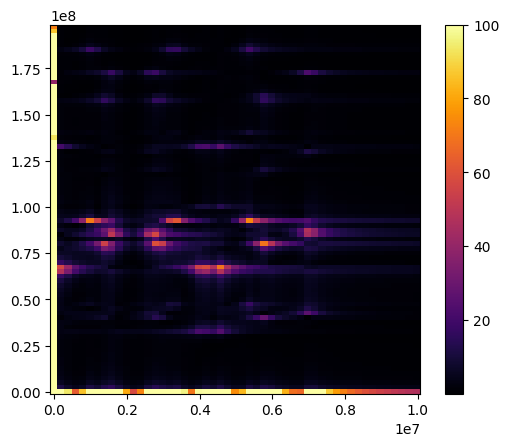

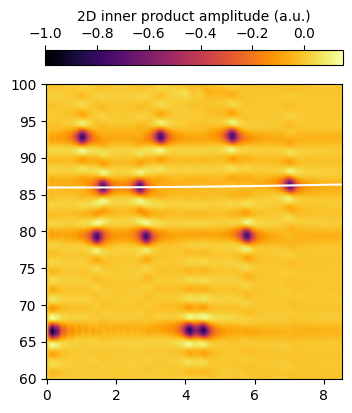

In [19]:
from bff_paper_figures.imshow_extensions import imshow_with_extents_and_crop
from bff_paper_figures.inner_product_functions import double_cosine_inner_product, inner_product_sinusoid

rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

rabifreqs=np.sort(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
ramsey_max = 10e6 # 3*np.linalg.norm(np.array(B_FIELD_VECTOR_T)*gammab) + 2*2.16e6
rabi_max = RABI_FREQ_BASE_HZ*2

fourier_transform_sq_subtracted = np.fft.fft2(sq_cancelled_signal)
fourier_transform_sq_subtracted  = np.fft.fftshift(fourier_transform_sq_subtracted)
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(fourier_transform_sq_subtracted), ymin=0, ymax=rabi_max, xmin=0, xmax=ramsey_max, vmax=100)
plt.colorbar()
plt.show()

rabifreqs = np.linspace(60e6, 100e6, 201)
ramseyfreqs = np.linspace(0, 8.5e6, 251)

inner_product_settings.use_effective_rabi_frequency=False
inner_product_settings.rabi_window="boxcar"

dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
imshow_with_extents_and_crop(1e-6*ramseyfreqs,1e-6*rabifreqs, -dtft/min(dtft.flatten()),ymin=60, ymax=100, xmin=0, xmax=8.5)
plt.colorbar(orientation="horizontal",location="top", shrink=0.6, label="2D inner product amplitude (a.u.)")
plt.plot(1e-6*ramseyfreqs, np.sqrt((1e-6*rabi_frequencies[3])**2 + (1e-6*ramseyfreqs)**2), color="white")
plt.savefig("double_inner_product.svg")
plt.show()


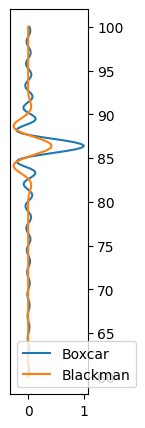

In [18]:
from scipy.signal import windows
fake_signal = np.cos(2*np.pi*np.sqrt(rabi_frequencies[3]**2 +max(ramseyfreqs)**2)*MW_PULSE_LENGTH_S)
blackman_window = windows.get_window("blackman", len(MW_PULSE_LENGTH_S))

boxcar_filter_function=np.array([inner_product_sinusoid(np.cos, rabi_hz, MW_PULSE_LENGTH_S, fake_signal) for rabi_hz in rabifreqs])
blackman_filter_function=np.array([inner_product_sinusoid(np.cos, rabi_hz, MW_PULSE_LENGTH_S, fake_signal*blackman_window) for rabi_hz in rabifreqs])

fig = plt.figure(0,(1,5))
plt.plot(boxcar_filter_function,1e-6*rabifreqs, label="Boxcar")
plt.plot(blackman_filter_function,1e-6*rabifreqs, label="Blackman")
plt.gca().yaxis.set_ticks_position("right")
plt.legend(loc="lower left")
plt.savefig("filter_functions.svg")


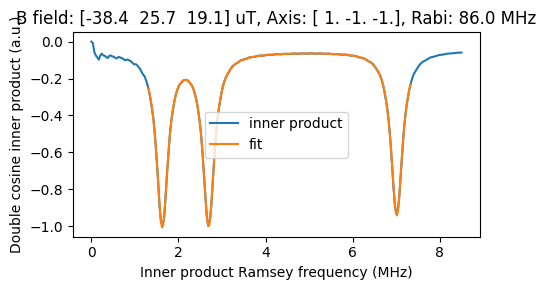

In [20]:
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    plot_fit_vs_inner_product,
    fit_vs_eigenvalue_error_nT,
    extract_fit_centers,
)
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues

inner_product_settings.use_effective_rabi_frequency=True
inner_product_settings.rabi_window="blackman"

larmor_freqs_all_axes_hz, bz_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

orientation = 3

cos_cos_inner_prod_init = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[orientation], RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
first_attempt_peaks = extract_fit_centers(
    fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init, T2STAR_S)
)

min_ramsey_freq_hz = max(2 / (np.pi * T2STAR_S), min(first_attempt_peaks) - 2 / (np.pi * T2STAR_S))
max_ramsey_freq_hz = max(first_attempt_peaks) + 2 / (np.pi * T2STAR_S)
ramsey_freq_range_constrained_hz = np.linspace(min_ramsey_freq_hz, max_ramsey_freq_hz, N_RAMSEY_POINTS)
cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freq_range_constrained_hz, inner_product_settings
)
fit_result = fit_constrained_hyperfine_peaks(
    ramsey_freq_range_constrained_hz, cos_cos_inner_prod, T2STAR_S, constrain_same_width=True,allow_zero_peak=True
)

#fit_peaks = extract_fit_centers(fit_result)
#plt.vlines(
#    HZ_TO_MHZ * fit_peaks,
#   [max(cos_cos_inner_prod)],
#    [min(cos_cos_inner_prod)],
#    label="fitted peaks",
#    color="red",
#)

fig = plt.figure(0,(5,3))

renormalization =np.abs(min(cos_cos_inner_prod_init))

plt.plot(HZ_TO_MHZ * RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init/renormalization, label="inner product")
plt.plot(HZ_TO_MHZ * ramsey_freq_range_constrained_hz, fit_result.best_fit/renormalization, label="fit")
plt.xlabel("Inner product Ramsey frequency (MHz)")
plt.ylabel("Double cosine inner product (a.u.)")
plt.legend()

errors_nT = fit_vs_eigenvalue_error_nT(fit_result, larmor_freqs_all_axes_hz[orientation])
plt.title(
    f"B field: {np.array2string(T_TO_UT * np.array(b_field_vector_t), precision=1)} uT, Axis: {np.array2string(np.sqrt(3) * NVaxes_100[orientation], precision=0)}, Rabi: {rabi_frequencies[orientation] * 1e-6:.1f} MHz" #\nErrors: {np.array2string(errors_nT, precision=2)} nT"
)
plt.tight_layout()
plt.savefig("example_fit.svg")
plt.show()

## Trying to understand the origin of the "zero" peak

In [76]:
import numpy as np
from bff_simulator.constants import f_h
MW_PULSE_LENGTH_S = np.arange(0, 1000e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 30e-6, 10e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6

ramsey_freq_hz = 1e6
rabi_freq_hz = 60e6
fake_signal = np.array([[-np.exp(-2*tau_s/T2STAR_S)*(
    np.cos(4*np.pi*ramsey_freq_hz*tau_s)
    +np.cos(4*np.pi*(ramsey_freq_hz-f_h)*tau_s)
    +np.cos(4*np.pi*(ramsey_freq_hz+ f_h)*tau_s)
    )*np.cos(2*np.pi*rabi_freq_hz*pulse_s) for tau_s in EVOLUTION_TIME_S] for pulse_s in MW_PULSE_LENGTH_S])
fake_signal.shape

(400, 3000)

-1.3401421937870053


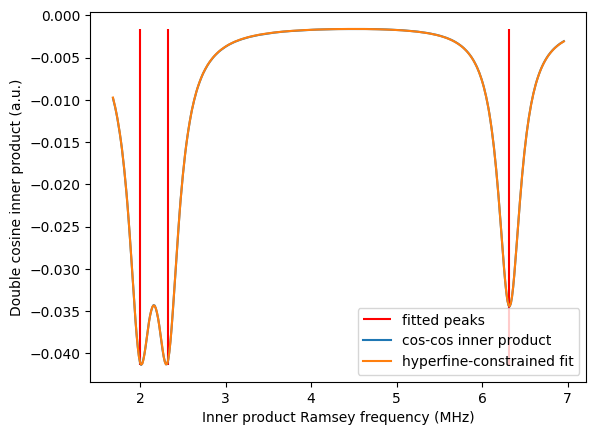

In [77]:
import numpy as np
from bff_simulator.constants import gammab
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.fitting_routines import plot_fit_vs_inner_product, extract_fit_centers, fit_constrained_hyperfine_peaks
from bff_paper_figures.inner_product_functions import double_cosine_inner_product, double_cosine_inner_product_vs_ramsey

N_RAMSEY_POINTS = 401
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="boxcar",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=False,
)

cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
first_attempt_peaks = extract_fit_centers(
    fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod, T2STAR_S, allow_zero_peak=False)
)

min_ramsey_freq_hz = max(0*2 / (np.pi * T2STAR_S), min(first_attempt_peaks) - 2 / (np.pi * T2STAR_S))
max_ramsey_freq_hz = max(first_attempt_peaks) + 2*2 / (np.pi * T2STAR_S)
ramsey_freq_range_constrained_hz = np.linspace(min_ramsey_freq_hz, max_ramsey_freq_hz, N_RAMSEY_POINTS)
cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, ramsey_freq_range_constrained_hz, inner_product_settings
)
fit_result = fit_constrained_hyperfine_peaks(
    ramsey_freq_range_constrained_hz, cos_cos_inner_prod, T2STAR_S, constrain_same_width=True, allow_zero_peak= False,
)

plot_fit_vs_inner_product(ramsey_freq_range_constrained_hz, cos_cos_inner_prod, fit_result)

print(1e9*(fit_result.params["p0_center"].value - 2*(ramsey_freq_hz+f_h))/(2*gammab))


Okay, so I see the same behaviour with "pure" sinsoids. Could this be coming from the effective Rabi frequency?

In [45]:
import numpy as np
from bff_simulator.constants import f_h
MW_PULSE_LENGTH_S = np.arange(0, 500e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 15e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6

ramsey_freq_hz = 2e6
rabi_freq_hz = 60e6
fake_signal = np.array([[-np.exp(-2*tau_s/T2STAR_S)*(
    np.cos(4*np.pi*ramsey_freq_hz*tau_s)*np.cos(2*np.pi*np.sqrt(rabi_freq_hz**2 + 4*ramsey_freq_hz**2)*pulse_s)
    +np.cos(4*np.pi*(ramsey_freq_hz-f_h)*tau_s)*np.cos(2*np.pi*np.sqrt(rabi_freq_hz**2 + 4*(ramsey_freq_hz-f_h)**2)*pulse_s)
    +np.cos(4*np.pi*(ramsey_freq_hz+ f_h)*tau_s)*np.cos(2*np.pi*np.sqrt(rabi_freq_hz**2 + 4*(ramsey_freq_hz+f_h)**2)*pulse_s)
    ) for tau_s in EVOLUTION_TIME_S] for pulse_s in MW_PULSE_LENGTH_S])
fake_signal.shape

(200, 750)

-65.63917991705239


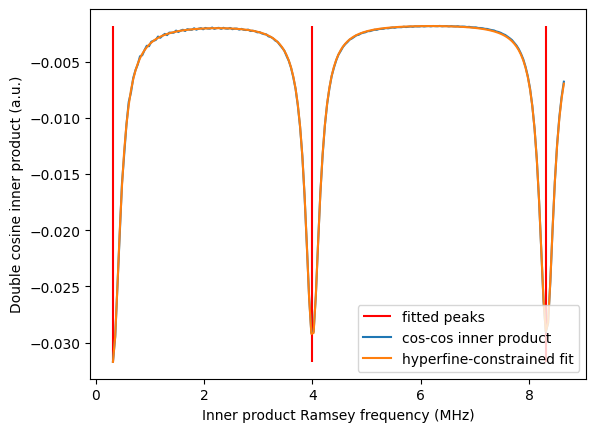

In [ ]:
import numpy as np
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.fitting_routines import plot_fit_vs_inner_product

N_RAMSEY_POINTS = 201
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)

cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
first_attempt_peaks = extract_fit_centers(
    fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod, T2STAR_S)
)

min_ramsey_freq_hz = max(2 / (np.pi * T2STAR_S), min(first_attempt_peaks) - 2 / (np.pi * T2STAR_S))
max_ramsey_freq_hz = max(first_attempt_peaks) + 2 / (np.pi * T2STAR_S)
ramsey_freq_range_constrained_hz = np.linspace(min_ramsey_freq_hz, max_ramsey_freq_hz, N_RAMSEY_POINTS)
cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, ramsey_freq_range_constrained_hz, inner_product_settings
)
fit_result = fit_constrained_hyperfine_peaks(
    ramsey_freq_range_constrained_hz, cos_cos_inner_prod, T2STAR_S, constrain_same_width=True, allow_zero_peak= True,
)

plot_fit_vs_inner_product(ramsey_freq_range_constrained_hz, cos_cos_inner_prod, fit_result)

print(fit_result.params["p0_center"].value - 2*(ramsey_freq_hz+f_h))


In [42]:
print(fit_result.fit_report())

[[Model]]
    ((((Model(lorentzian, prefix='p0_') + Model(lorentzian, prefix='p1_')) + Model(lorentzian, prefix='p2_')) + Model(offset)) + Model(lorentzian, prefix='zero_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3093
    # data points      = 201
    # variables        = 8
    chi-square         = 1.0357e-07
    reduced chi-square = 5.3664e-10
    Akaike info crit   = -4282.64711
    Bayesian info crit = -4256.22067
    R-squared          = 0.99999495
[[Variables]]
    p0_center:       6319976.57 +/- 33.2404425 (0.00%) (init = 6316269)
    p0_fwhm:         317983.333 +/- 146.554342 (0.05%) (init = 318309.9)
    p0_amplitude:   -0.02781026 +/- 1.3113e-05 (0.05%) (init = -0.03542559)
    p1_center:       1999976.57 +/- 33.2404425 (0.00%) == 'abs(p0_center - 2*1*2160000.0)'
    p1_fwhm:         317983.333 +/- 146.554342 (0.05%) == 'p0_fwhm'
    p1_amplitude:   -0.02798390 +/- 1.1498e-05 (0.04%) (init = -0.03542559)
    p2_center:       2320023.43 +/- 

In [44]:
from bff_simulator.constants import gammab
262/(2*gammab)

4.674564658863831e-09

## Trying to get an accurate inversion of a simple signal

### Hyperfine signal

In [157]:
import numpy as np
from bff_simulator.constants import f_h
MW_PULSE_LENGTH_S = np.arange(0, 500e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 30e-6, 2e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6

ramsey_freq_hz = 1e6
rabi_freq_hz = 60e6
fake_signal = np.array([[-np.exp(-2*tau_s/T2STAR_S)*(
    np.cos(4*np.pi*ramsey_freq_hz*tau_s)
    +np.cos(4*np.pi*(ramsey_freq_hz-f_h)*tau_s)
    +np.cos(4*np.pi*(ramsey_freq_hz+ f_h)*tau_s)
    )*np.cos(2*np.pi*rabi_freq_hz*pulse_s) for tau_s in EVOLUTION_TIME_S] for pulse_s in MW_PULSE_LENGTH_S])
fake_signal.shape

(200, 15000)

-1.3492939380057902


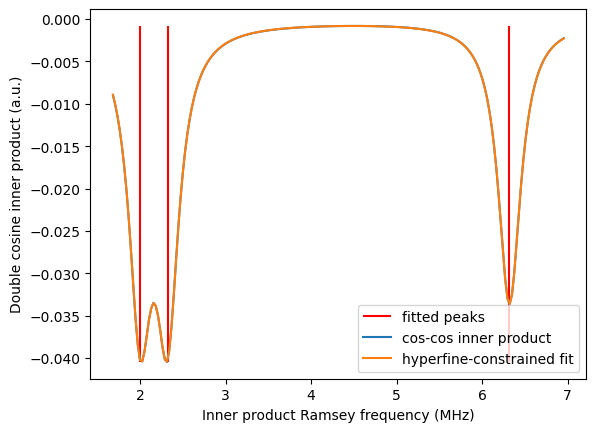

In [158]:
import numpy as np
from bff_simulator.constants import gammab
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.fitting_routines import plot_fit_vs_inner_product, extract_fit_centers, fit_constrained_hyperfine_peaks
from bff_paper_figures.inner_product_functions import double_cosine_inner_product, double_cosine_inner_product_vs_ramsey

N_RAMSEY_POINTS = 201
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="boxcar",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=False,
)

cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
first_attempt_peaks = extract_fit_centers(
    fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod, T2STAR_S, allow_zero_peak=False)
)

min_ramsey_freq_hz = max(0*2 / (np.pi * T2STAR_S), min(first_attempt_peaks) - 2 / (np.pi * T2STAR_S))
max_ramsey_freq_hz = max(first_attempt_peaks) + 2*2 / (np.pi * T2STAR_S)
ramsey_freq_range_constrained_hz = np.linspace(min_ramsey_freq_hz, max_ramsey_freq_hz, N_RAMSEY_POINTS)
cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, ramsey_freq_range_constrained_hz, inner_product_settings
)
fit_result = fit_constrained_hyperfine_peaks(
    ramsey_freq_range_constrained_hz, cos_cos_inner_prod, T2STAR_S, constrain_same_width=True, allow_zero_peak= False,
)

plot_fit_vs_inner_product(ramsey_freq_range_constrained_hz, cos_cos_inner_prod, fit_result)

print(1e9*(fit_result.params["p0_center"].value - 2*(ramsey_freq_hz+f_h))/(2*gammab))

### Single peak signal

In [190]:
import numpy as np
from bff_simulator.constants import f_h
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 15e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6

ramsey_freq_hz = 1e6
rabi_freq_hz = 60e6
fake_signal = np.array([[-np.exp(-2*tau_s/T2STAR_S)*(
    np.cos(4*np.pi*ramsey_freq_hz*tau_s)
    )*np.cos(2*np.pi*rabi_freq_hz*pulse_s) for tau_s in EVOLUTION_TIME_S] for pulse_s in MW_PULSE_LENGTH_S])
fake_signal.shape

(160, 750)

np.float64(-1.1692266676925487)

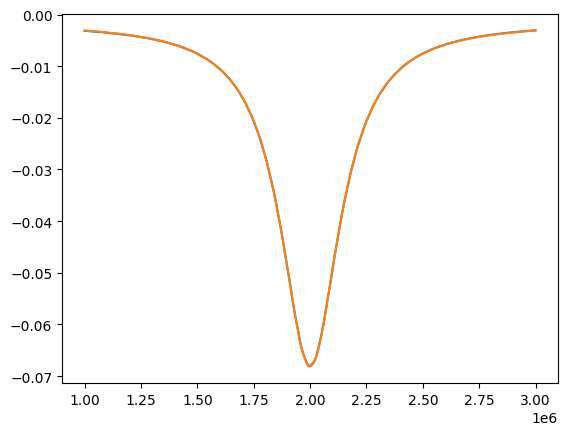

In [191]:
import numpy as np
from bff_simulator.constants import gammab
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.fitting_routines import plot_fit_vs_inner_product, extract_fit_centers, fit_constrained_hyperfine_peaks
from bff_paper_figures.inner_product_functions import double_cosine_inner_product, double_cosine_inner_product_vs_ramsey
from lmfit import Model

N_RAMSEY_POINTS = 201
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(1e6, 3e6, N_RAMSEY_POINTS)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="boxcar",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=False,
)

cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    fake_signal, rabi_freq_hz, RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)


def offset(x: float, offset_value: float) -> float:
    return offset_value


def lorentzian(x: float, center: float, fwhm: float, amplitude: float) -> float:
    return amplitude / (1 + 4 * (x - center) ** 2 / fwhm**2)

inner_product_data = cos_cos_inner_prod
ramsey_freqs_range_hz = RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ
peak = Model(lorentzian)
offset_model = Model(offset)
one_peak_model = peak + offset_model
params = one_peak_model.make_params()
params["offset_value"].value = 0
params["amplitude"].value = min(inner_product_data)
params[f"center"].value = 2.1*ramsey_freq_hz
params[f"fwhm"].value = 2.1 / (np.pi * T2STAR_S)
result = one_peak_model.fit(inner_product_data, params, x=ramsey_freqs_range_hz)

plt.plot(ramsey_freqs_range_hz, inner_product_data, label="cos-cos inner product")
plt.plot(ramsey_freqs_range_hz, result.best_fit, label="hyperfine-constrained fit")

1e9*(result.params["center"].value - 2*ramsey_freq_hz)/(2*gammab)


Can we do better by time domain fitting??

np.float64(-7.93438712137616e-10)

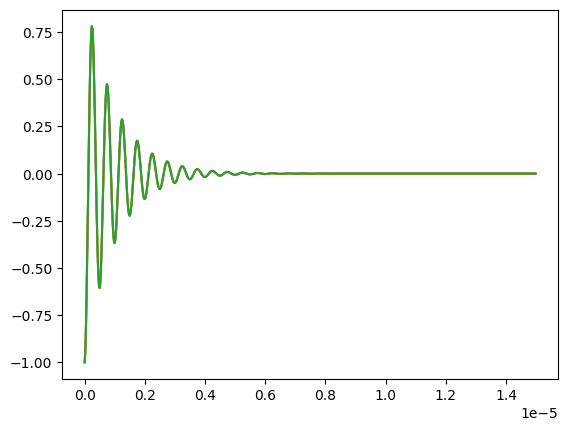

In [195]:
from bff_paper_figures.inner_product_functions import inner_product_sinusoid

time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_freq_hz, MW_PULSE_LENGTH_S, fake_signal.transpose(), axis=1)
plt.plot(EVOLUTION_TIME_S, time_domain_ramsey_signal)

def offset(x: float, offset_value: float) -> float:
    return offset_value


def decaying_cosine(x: float, freq: float, decay_time: float, amplitude: float) -> float:
    return amplitude * np.exp(-x/decay_time)*np.cos(2*np.pi*freq*x)

data = time_domain_ramsey_signal
xaxis = EVOLUTION_TIME_S
cos_decay_model = Model(decaying_cosine)
offset_model = Model(offset)
offset_cos_decay_model = cos_decay_model + offset_model
params = offset_cos_decay_model.make_params()
params["offset_value"].value = 0
params["amplitude"].value = max(data)
params[f"freq"].value = 2.1*ramsey_freq_hz
params[f"decay_time"].value = 0.6 * T2STAR_S
result = offset_cos_decay_model.fit(data, params, x=xaxis)

plt.plot(xaxis, data, label="ramsey")
plt.plot(xaxis, result.best_fit, label="fit")

1e9*(result.params["freq"].value - 2*ramsey_freq_hz)/(2*gammab)

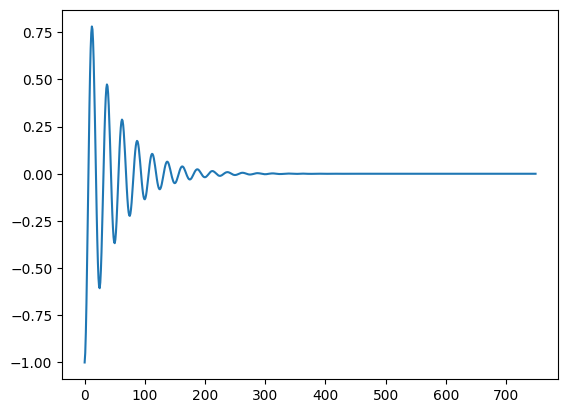

## Trying for a time-domain fit...sigh...

theta = 0.79, phi = 2.23, largest eigenvalue errors = [-0.59  2.97 -0.66  0.8 ] nT


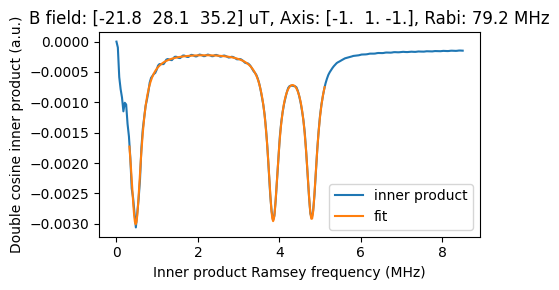

In [6]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt

from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    fit_vs_eigenvalue_error_all_orientations_nT,
    fit_vs_eigenvalue_error_nT,
    extract_fit_centers,
)
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues


from bff_simulator.constants import exy, NVaxes_100
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
)

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  .79 #3*np.pi/8
B_PHI = 2.23 #5*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 8.5e6, N_RAMSEY_POINTS)

RUN_LABEL = f"b_{B_MAGNITUDE_T*T_TO_UT:.0f}_ut_t2s_{T2STAR_S*1e6:.0f}_us"
orientation = 1

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(B_THETA)*np.cos(B_PHI), np.sin(B_THETA)*np.sin(B_PHI), np.cos(B_THETA)])
exp_param_factory.set_b_field_vector(b_field_vector_t)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

# Full inversion
inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())
larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

fit_results = double_cosine_inner_product_fit_inversion(
    sq_cancelled_signal,
    exp_param_factory.get_experiment_parameters(),
    inner_product_settings,
    RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
    T2STAR_S,
    constrain_same_width=True,
    allow_zero_peak=True,
)
errors_nT = fit_vs_eigenvalue_error_all_orientations_nT(fit_results, larmor_freqs_all_axes_hz)
print(f"theta = {B_THETA:.2f}, phi = {B_PHI:.2f}, largest eigenvalue errors = {np.array2string(errors_nT[:, 0], precision=2)} nT")

# Example orientation
cos_cos_inner_prod_init = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[orientation], RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
first_attempt_peaks = extract_fit_centers(
    fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init, T2STAR_S)
)

min_ramsey_freq_hz = max(2 / (np.pi * T2STAR_S), min(first_attempt_peaks) - 2 / (np.pi * T2STAR_S))
max_ramsey_freq_hz = max(first_attempt_peaks) + 2 / (np.pi * T2STAR_S)
ramsey_freq_range_constrained_hz = np.linspace(min_ramsey_freq_hz, max_ramsey_freq_hz, N_RAMSEY_POINTS)
cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freq_range_constrained_hz, inner_product_settings
)
fit_result = fit_constrained_hyperfine_peaks(
    ramsey_freq_range_constrained_hz, cos_cos_inner_prod, T2STAR_S, constrain_same_width=True,allow_zero_peak=True
)

fig = plt.figure(0,(5,3))

renormalization = 1# np.abs(min(cos_cos_inner_prod_init))

plt.plot(HZ_TO_MHZ * RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init/renormalization, label="inner product")
plt.plot(HZ_TO_MHZ * ramsey_freq_range_constrained_hz, fit_result.best_fit/renormalization, label="fit")
plt.xlabel("Inner product Ramsey frequency (MHz)")
plt.ylabel("Double cosine inner product (a.u.)")
plt.legend()

errors_nT = fit_vs_eigenvalue_error_nT(fit_result, larmor_freqs_all_axes_hz[orientation])
plt.title(
    f"B field: {np.array2string(T_TO_UT * np.array(b_field_vector_t), precision=1)} uT, Axis: {np.array2string(np.sqrt(3) * NVaxes_100[orientation], precision=0)}, Rabi: {rabi_frequencies[orientation] * 1e-6:.1f} MHz" #\nErrors: {np.array2string(errors_nT, precision=2)} nT"
)
plt.tight_layout()
plt.savefig("example_fit.svg")
plt.show()

0.30625993630506126
2.965001191548012
1.8363506542656154
2.948589769855064
1.7260355429025036
2.949007754890068


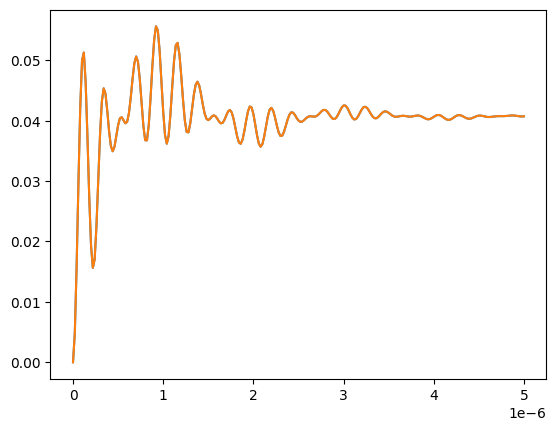

In [7]:
from bff_paper_figures.inner_product_functions import inner_product_sinusoid
from scipy.signal import windows
from bff_simulator.constants import f_h, gammab
from lmfit import Model

rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())
rabi_window = windows.get_window("blackman", len(MW_PULSE_LENGTH_S))
time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_frequencies[orientation], MW_PULSE_LENGTH_S, rabi_window*np.transpose(sq_cancelled_signal),axis=1)
plt.plot(EVOLUTION_TIME_S, time_domain_ramsey_signal)

def offset(x: float, offset_value: float) -> float:
    return offset_value

def decaying_cosine(x: float, freq: float, decay_time: float, amplitude: float, phase: float) -> float:
    return amplitude * np.exp(-x/decay_time)*np.cos(2*np.pi*freq*x + phase)

n_hyperfine=3
signal_amp = (max(time_domain_ramsey_signal) - min(time_domain_ramsey_signal))/2

model = Model(offset)
for i in range(n_hyperfine):
    model += Model(decaying_cosine, prefix=f"c{i}_")
params = model.make_params()
params["offset_value"].value = 0
for i in range(n_hyperfine):
    params[f"c{i}_amplitude"].value =  signal_amp/n_hyperfine
    params[f"c{i}_phase"].value = 0
    params[f"c{i}_phase"].vary = True
    params[f"c{i}_decay_time"].value = T2STAR_S/2
    params[f"c{i}_freq"].value = fit_result.params[f"p{i}_center"].value
    if i==0:
        #params[f"c0_freq"].value = fit_result.params["p0_center"].value
        pass
    else:
        #params[f"c{i}_freq"].expr = f"abs(c0_freq - 2*{i}*{f_h})"
        #params[f"c{i}_decay_time"].expr = "c0_decay_time"
        pass

time_domain_result = model.fit(time_domain_ramsey_signal, params, x=EVOLUTION_TIME_S)
plt.plot(EVOLUTION_TIME_S, time_domain_result.best_fit)
for i in range(n_hyperfine):
    print(1e9*min(np.abs((time_domain_result.params[f"c{i}_freq"].value - np.array(larmor_freqs_all_axes_hz[orientation]))/(2*gammab))))
    print(1e9*min(np.abs(fit_result.params[f"p{i}_center"].value - np.array(larmor_freqs_all_axes_hz[orientation]))/(2*gammab)))


In [22]:
import numpy as np
from math import floor
theta = np.linspace(0, np.pi, 91)[18]
b_phi_n = max(5, floor(np.sin(theta)*181))
print(theta*360/(2*np.pi))
phi = np.linspace(0, np.pi, b_phi_n)[82]
print(phi*360/(2*np.pi))
b_field_vector_t = 50e-6*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

36.0
140.57142857142858


21.146732217557393
15.405760282637152
5.427119216041295


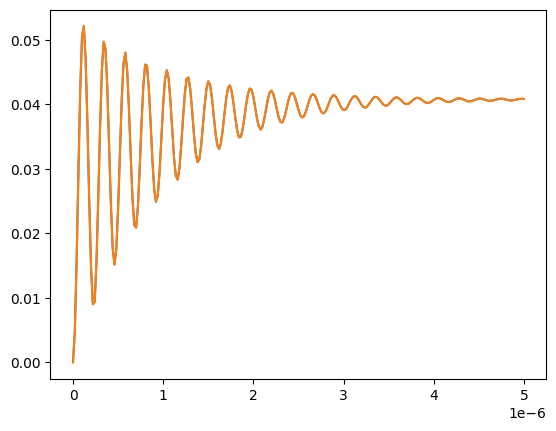

In [19]:

import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import windows
from bff_paper_figures.inner_product_functions import InnerProductSettings, inner_product_sinusoid, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    fit_three_cos_model,
    extract_fit_centers,
    N_HYPERFINE
)
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues


from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
)

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  .79 #3*np.pi/8
B_PHI = 2.23 #5*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 8.5e6, N_RAMSEY_POINTS)

RUN_LABEL = f"b_{B_MAGNITUDE_T*T_TO_UT:.0f}_ut_t2s_{T2STAR_S*1e6:.0f}_us"
orientation = 1

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

#b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(B_THETA)*np.cos(B_PHI), np.sin(B_THETA)*np.sin(B_PHI), np.cos(B_THETA)])
exp_param_factory.set_b_field_vector(b_field_vector_t)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)


rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
cos_cos_inner_prod_init = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[orientation], RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
peak_fit_result = fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init, T2STAR_S)
freq_guesses = extract_fit_centers(peak_fit_result)

rabi_window = windows.get_window(inner_product_settings.rabi_window, len(MW_PULSE_LENGTH_S))
time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_frequencies[orientation], MW_PULSE_LENGTH_S, rabi_window*np.transpose(sq_cancelled_signal),axis=1)

time_domain_result = fit_three_cos_model(EVOLUTION_TIME_S, time_domain_ramsey_signal, freq_guesses, T2STAR_S, False, True, False)
plt.plot(EVOLUTION_TIME_S, time_domain_ramsey_signal)
plt.plot(EVOLUTION_TIME_S, time_domain_result.best_fit)

larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
for i in range(N_HYPERFINE):
    print(1e9*min(np.abs((time_domain_result.params[f"p{i}_freq"].value - np.array(larmor_freqs_all_axes_hz[orientation]))/(2*gammab))))


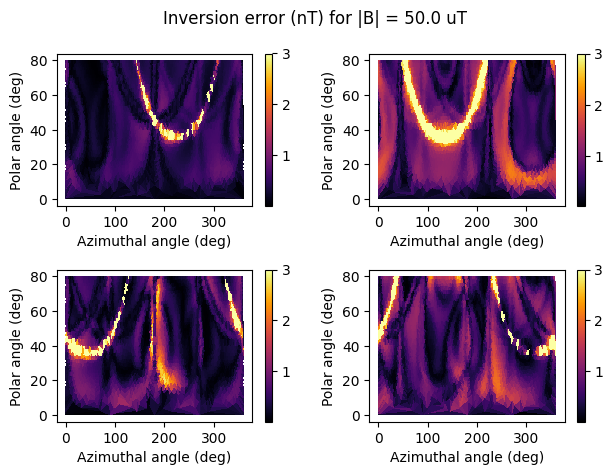

In [2]:
T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6
B_MAGNITUDE_T = 50e-6
T2STAR_S = 2e-6
RUN_LABEL = f"b_{B_MAGNITUDE_T*T_TO_UT:.0f}_ut_t2s_{T2STAR_S*1e6:.0f}_us_apr16"
base_path = "/Users/lilianchildress/Documents/GitHub/sbq-dq-simulator/"

errors_vs_b_freq_domain_nT = list(np.loadtxt(base_path+f"errors_nt_freq_{RUN_LABEL}.txt"))
errors_vs_b_time_domain_nT = list(np.loadtxt(base_path+f"errors_nt_time_{RUN_LABEL}.txt", ))
phi_values = list(np.loadtxt(base_path+f"phi_values_{RUN_LABEL}.txt"))
theta_values = list(np.loadtxt(base_path+ f"theta_values_{RUN_LABEL}.txt"))
problem_phi_values = list(np.loadtxt(base_path+f"problem_phi_values_{RUN_LABEL}.txt"))
problem_theta_values = list(np.loadtxt(base_path+ f"problem_theta_values_{RUN_LABEL}.txt"))

for i,orientation in enumerate(NVOrientation):
    plt.subplot(2,2,i+1)
    plt.tripcolor(np.array(phi_values)*360/(2*np.pi), np.array(theta_values)*360/(2*np.pi), np.abs(np.array(errors_vs_b_time_domain_nT)[:,orientation]),  cmap="inferno", vmax=3)
    plt.colorbar()
    plt.xlabel("Azimuthal angle (deg)")
    plt.ylabel("Polar angle (deg)")
    #plt.title(
    #    f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[orientation], precision=0)}, Rabi: {rabi_frequencies[orientation] * 1e-6:.1f} MHz", fontsize=10
    #)
plt.suptitle(f"Inversion error (nT) for |B| = {B_MAGNITUDE_T *T_TO_UT} uT")
plt.tight_layout()
plt.show()

In [5]:
test_theta = theta_values[0]
test_phi = phi_values[44]
theta_indices = np.where(np.isclose(theta_values, test_theta))
phi_indices = np.where(np.isclose(phi_values, test_phi))
len(np.intersect1d(theta_indices, phi_indices))

0

theta = 0.66, phi = 5.08, freq domain errors = [  0.35   0.94  -0.83 261.74] nT
	 	 	 time domain fit errors = [ 0.577  0.607 -0.032 -4.21 ] nT


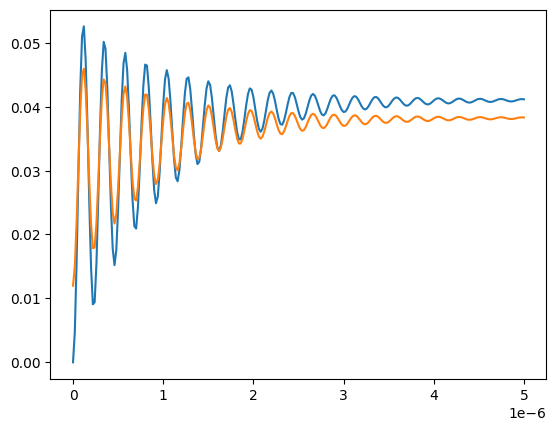

In [6]:
import numpy as np
from math import floor
from matplotlib import pyplot as plt
from scipy.signal import windows

from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion
)
from bff_paper_figures.inner_product_functions import InnerProductSettings, inner_product_sinusoid
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import set_up_three_cos_model,fit_three_cos_model,fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA_START = 0
B_THETA_STOP = np.pi
B_THETA_N = 21

B_PHI_START = 0
B_PHI_STOP = 2*np.pi
B_PHI_N_MAX = 41
B_PHI_N_MIN = 5

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # Which frequency we will be comparing to expected value; 0 is highest-frequency peak


RUN_LABEL = f"b_{B_MAGNITUDE_T*T_TO_UT:.0f}_ut_t2s_{T2STAR_S*1e6:.0f}_us_apr16"
base_path = "/Users/lilianchildress/Documents/GitHub/sbq-dq-simulator/"

errors_vs_b_freq_domain_nT = list(np.loadtxt(base_path+f"errors_nt_freq_{RUN_LABEL}.txt"))
errors_vs_b_time_domain_nT = list(np.loadtxt(base_path+f"errors_nt_time_{RUN_LABEL}.txt", ))
phi_values = list(np.loadtxt(base_path+f"phi_values_{RUN_LABEL}.txt"))
theta_values = list(np.loadtxt(base_path+ f"theta_values_{RUN_LABEL}.txt"))
problem_phi_values = list(np.loadtxt(base_path+f"problem_phi_values_{RUN_LABEL}.txt"))
problem_theta_values = list(np.loadtxt(base_path+ f"problem_theta_values_{RUN_LABEL}.txt"))

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())


phi = problem_phi_values[4]
theta = problem_theta_values[4]  
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
exp_param_factory.set_b_field_vector(b_field_vector_t)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

larmor_freqs_all_axes_hz, bz_values_all_axes_t = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())

# frequency domain inversion
peakfit_results = double_cosine_inner_product_fit_inversion(
    sq_cancelled_signal,
    exp_param_factory.get_experiment_parameters(),
    inner_product_settings,
    RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
    T2STAR_S,
    constrain_same_width=True,
    allow_zero_peak=True,
)
errors_fd_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
print(f"theta = {theta:.2f}, phi = {phi:.2f}, freq domain errors = {np.array2string(errors_fd_nT[:, PEAK_INDEX], precision=2)} nT") 

# time domain inversion
freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
off_axis_experiment_parameters=exp_param_factory.get_experiment_parameters()
rabi_frequencies = get_bare_rabi_frequencies(off_axis_experiment_parameters)
mw_pulse_length_s = off_axis_experiment_parameters.mw_pulse_length_s
evolution_time_s = off_axis_experiment_parameters.evolution_time_s
fit_results = []
rabi_window = windows.get_window(inner_product_settings.rabi_window, len(mw_pulse_length_s))
orientation = NVOrientation.D
time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_frequencies[orientation], mw_pulse_length_s, rabi_window*np.transpose(sq_cancelled_signal),axis=1)
plt.plot(evolution_time_s, time_domain_ramsey_signal)
signal_amp = (max(time_domain_ramsey_signal) - min(time_domain_ramsey_signal))/2
model, params = set_up_three_cos_model(time_domain_ramsey_signal, freq_guesses_all_orientations[orientation], T2STAR_S, fix_phase_to_zero=False, constrain_same_decay=True, constrain_hyperfine_freqs=True)
plt.plot(evolution_time_s, model.eval(params, x=evolution_time_s))

time_domain_result = fit_three_cos_model(evolution_time_s, time_domain_ramsey_signal, freq_guesses_all_orientations[orientation], T2STAR_S, False, True,True)
fit_results.append(time_domain_result)




time_domain_fit_results = time_domain_fit_inversion(
    sq_cancelled_signal, 
    exp_param_factory.get_experiment_parameters(), 
    inner_product_settings, 
    freq_guesses_all_orientations, 
    T2STAR_S,
    fix_phase_to_zero= False,
    constrain_same_decay= True,
    constrain_hyperfine_freqs= True)
errors_td_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
print(f"\t \t \t time domain fit errors = {np.array2string(errors_td_nT[:, PEAK_INDEX], precision=3)} nT")

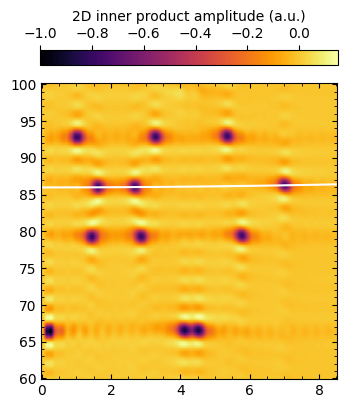

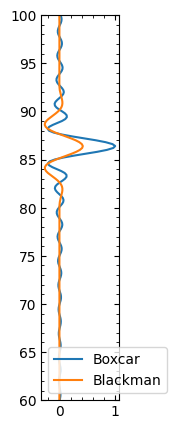

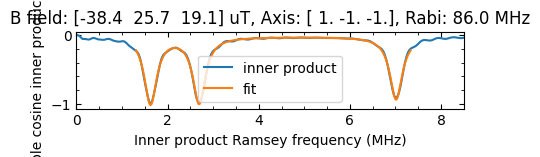

Peak fit errors: [ 14.23  14.22 -14.22]


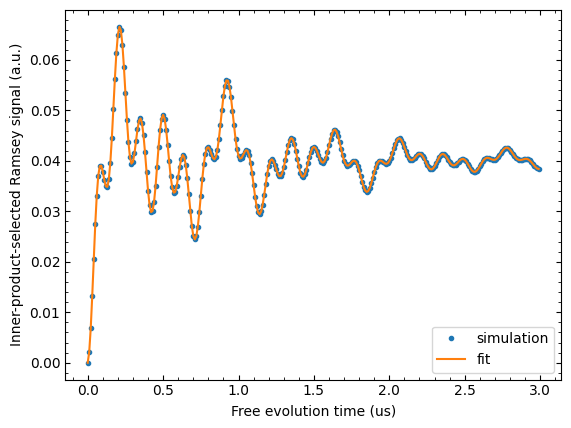

Time domain fit errors: [ 0.35  0.35 -0.35]


In [131]:
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.optimize import fsolve
from scipy.signal import windows
from bff_simulator.constants import f_h, gammab, exy, NVaxes_100
from bff_paper_figures.imshow_extensions import imshow_with_extents_and_crop
from bff_paper_figures.inner_product_functions import double_cosine_inner_product, inner_product_sinusoid
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import sq_cancelled_signal_generator
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_nT
from bff_paper_figures.imshow_extensions import imshow_with_extents_and_crop
from bff_paper_figures.inner_product_functions import InnerProductSettings, double_cosine_inner_product_vs_ramsey
from bff_paper_figures.fitting_routines import (
    fit_constrained_hyperfine_peaks,
    extract_fit_centers,
    set_up_three_cos_model,
    fit_three_cos_model
)


T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

# Generate the example data set at 50 uT and a fairly random field angle

MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_MAGNITUDE_T = 50e-6
B_THETA =  3*np.pi/8
B_PHI = 13*np.pi/16

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 10e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 8.5e6, N_RAMSEY_POINTS)

RAD_TO_DEGREE = 360/(2*np.pi)
PHI_RANGE_HALF_HYPERFINE = np.linspace(1.4607, 3.25133, 301)

EXAMPLE_ORIENTATION = 3

def double_cosine_inner_product(
    dq_signal: NDArray, rabi_freq_hz: float, ramsey_freq_hz: float, ips: InnerProductSettings
):
    if ips.use_effective_rabi_frequency:
        rabi_freq_hz = np.sqrt(rabi_freq_hz**2 + ramsey_freq_hz**2)

    rabi_window = windows.get_window(ips.rabi_window, len(ips.mw_pulse_durations_s))

    rabi_inner_product_cos = inner_product_sinusoid(
        np.cos, rabi_freq_hz, ips.mw_pulse_durations_s, rabi_window * np.transpose(dq_signal), axis=1
    )

#TO DO: Add in signal - 1 in the total sum (sum over both)?
    numerator = np.sum((np.cos(2 * np.pi * (rabi_freq_hz) * ips.mw_pulse_durations_s))* (np.transpose(dq_signal)), axis=1)
    denominator = np.sum(np.cos(2 * np.pi * (rabi_freq_hz) * ips.mw_pulse_durations_s)*np.cos(2 * np.pi * (rabi_freq_hz) * ips.mw_pulse_durations_s))
    rabi_inner_product_cos = numerator/denominator

    if ips.subtract_mean:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)

    ramsey_window = windows.get_window(ips.ramsey_window, len(ips.free_evolution_times_s))
    double_inner_product_cos_cos = inner_product_sinusoid(
        np.cos, ramsey_freq_hz, ips.free_evolution_times_s, ramsey_window * rabi_inner_product_cos, axis=0
    )

    return double_inner_product_cos_cos


nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
 
b_field_vector_t = B_MAGNITUDE_T*np.array([np.sin(B_THETA)*np.cos(B_PHI), np.sin(B_THETA)*np.sin(B_PHI), np.cos(B_THETA)])
exp_param_factory.set_b_field_vector(b_field_vector_t)
sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

# Plot the double inner product

rabifreqs = np.linspace(60e6, 100e6, 201)
ramseyfreqs = np.linspace(0, 8.5e6, 251)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="boxcar",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=False,
)

dtft = np.array([[double_cosine_inner_product(sq_cancelled_signal, rabi_hz, ramsey_hz, inner_product_settings) for ramsey_hz in ramseyfreqs] for rabi_hz in rabifreqs])
imshow_with_extents_and_crop(1e-6*ramseyfreqs,1e-6*rabifreqs, -dtft/min(dtft.flatten()),ymin=60, ymax=100, xmin=0, xmax=8.5)
plt.colorbar(orientation="horizontal",location="top", shrink=0.6, label="2D inner product amplitude (a.u.)")
plt.plot(1e-6*ramseyfreqs, np.sqrt((1e-6*rabi_frequencies[3])**2 + (1e-6*ramseyfreqs)**2), color="white")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both")
plt.savefig("double_inner_product.svg")
plt.show()

# Plot the associated filter function for boxcar and blackman

fake_signal = np.cos(2*np.pi*np.sqrt(rabi_frequencies[3]**2 +max(ramseyfreqs)**2)*MW_PULSE_LENGTH_S)
blackman_window = windows.get_window("blackman", len(MW_PULSE_LENGTH_S))

boxcar_filter_function=np.array([inner_product_sinusoid(np.cos, rabi_hz, MW_PULSE_LENGTH_S, fake_signal) for rabi_hz in rabifreqs])
blackman_filter_function=np.array([inner_product_sinusoid(np.cos, rabi_hz, MW_PULSE_LENGTH_S, fake_signal*blackman_window) for rabi_hz in rabifreqs])

fig = plt.figure(0,(1,5))
plt.plot(boxcar_filter_function,1e-6*rabifreqs, label="Boxcar")
plt.ylim((60, 100))
plt.plot(blackman_filter_function,1e-6*rabifreqs, label="Blackman")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both")
plt.legend(loc="lower left")
plt.savefig("filter_functions.svg")
plt.show()

# Do the fit (first fit is to set the fitting range)
inner_product_settings.use_effective_rabi_frequency=True
inner_product_settings.rabi_window="blackman"

cos_cos_inner_prod_init = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[EXAMPLE_ORIENTATION], RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, inner_product_settings
)
first_attempt_peaks = extract_fit_centers(
    fit_constrained_hyperfine_peaks(RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init, T2STAR_S)
)

min_ramsey_freq_hz = max(2 / (np.pi * T2STAR_S), min(first_attempt_peaks) - 2 / (np.pi * T2STAR_S))
max_ramsey_freq_hz = max(first_attempt_peaks) + 2 / (np.pi * T2STAR_S)
ramsey_freq_range_constrained_hz = np.linspace(min_ramsey_freq_hz, max_ramsey_freq_hz, N_RAMSEY_POINTS)
cos_cos_inner_prod = double_cosine_inner_product_vs_ramsey(
    sq_cancelled_signal, rabi_frequencies[EXAMPLE_ORIENTATION], ramsey_freq_range_constrained_hz, inner_product_settings
)
peakfit_result = fit_constrained_hyperfine_peaks(
    ramsey_freq_range_constrained_hz, cos_cos_inner_prod, T2STAR_S, constrain_same_width=True,allow_zero_peak=True
)

fig = plt.figure(0,(5,1))

renormalization =np.abs(min(cos_cos_inner_prod_init))

plt.plot(HZ_TO_MHZ * RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ, cos_cos_inner_prod_init/renormalization, label="inner product")
plt.plot(HZ_TO_MHZ * ramsey_freq_range_constrained_hz, peakfit_result.best_fit/renormalization, label="fit")
plt.xlabel("Inner product Ramsey frequency (MHz)")
plt.ylabel("Double cosine inner product (a.u.)")
plt.legend()

plt.title(
    f"B field: {np.array2string(T_TO_UT * np.array(b_field_vector_t), precision=1)} uT, Axis: {np.array2string(np.sqrt(3) * NVaxes_100[EXAMPLE_ORIENTATION], precision=0)}, Rabi: {rabi_frequencies[EXAMPLE_ORIENTATION] * 1e-6:.1f} MHz" #\nErrors: {np.array2string(errors_nT, precision=2)} nT"
)
plt.xlim(0, 8.5)
plt.gca().xaxis.set_ticks_position("both")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both")
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.savefig("example_fit.svg")
plt.show()

larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
errors_nT = fit_vs_eigenvalue_error_nT(peakfit_result, larmor_freqs_all_axes_hz[EXAMPLE_ORIENTATION])
print(f"Peak fit errors: {np.array2string(errors_nT, precision=2)}")

# Plot the time domain inversion for the same data set

freq_guesses = extract_fit_centers(peakfit_result)
off_axis_experiment_parameters=exp_param_factory.get_experiment_parameters()
mw_pulse_length_s = off_axis_experiment_parameters.mw_pulse_length_s
evolution_time_s = off_axis_experiment_parameters.evolution_time_s
rabi_window = windows.get_window(inner_product_settings.rabi_window, len(mw_pulse_length_s))

time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_frequencies[EXAMPLE_ORIENTATION], mw_pulse_length_s, rabi_window*np.transpose(sq_cancelled_signal),axis=1)
plt.plot(1e6*evolution_time_s, time_domain_ramsey_signal, marker=".", linestyle="", label="simulation")

time_domain_result = fit_three_cos_model(evolution_time_s, time_domain_ramsey_signal, freq_guesses, T2STAR_S, False, True,True)
plt.plot(1e6*evolution_time_s, time_domain_result.best_fit, label="fit")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both")
plt.legend(loc="lower right")
plt.xlabel("Free evolution time (us)")
plt.ylabel("Inner-product-selected Ramsey signal (a.u.)")
plt.show()

errors_nT = fit_vs_eigenvalue_error_nT(time_domain_result, larmor_freqs_all_axes_hz[EXAMPLE_ORIENTATION])
print(f"Time domain fit errors: {np.array2string(errors_nT, precision=2)}")


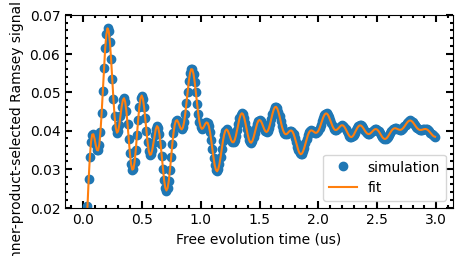

Time domain fit errors: [ 0.35  0.35 -0.35]


In [51]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
freq_guesses = extract_fit_centers(peakfit_result)
off_axis_experiment_parameters=exp_param_factory.get_experiment_parameters()
mw_pulse_length_s = off_axis_experiment_parameters.mw_pulse_length_s
evolution_time_s = off_axis_experiment_parameters.evolution_time_s
rabi_window = windows.get_window(inner_product_settings.rabi_window, len(mw_pulse_length_s))

time_domain_ramsey_signal = inner_product_sinusoid(np.cos, rabi_frequencies[EXAMPLE_ORIENTATION], mw_pulse_length_s, rabi_window*np.transpose(sq_cancelled_signal),axis=1)
plt.figure(0,(5,2.5))
plt.plot(1e6*evolution_time_s, time_domain_ramsey_signal, marker="o", linestyle="", label="simulation")
#signal_amp = (max(time_domain_ramsey_signal) - min(time_domain_ramsey_signal))/2
#model, params = set_up_three_cos_model(time_domain_ramsey_signal, freq_guesses, T2STAR_S, fix_phase_to_zero=False, constrain_same_decay=True, constrain_hyperfine_freqs=True)
#plt.plot(evolution_time_s, model.eval(params, x=evolution_time_s))

time_domain_result = fit_three_cos_model(evolution_time_s, time_domain_ramsey_signal, freq_guesses, T2STAR_S, False, True,True)
plt.plot(1e6*evolution_time_s, time_domain_result.best_fit, label="fit")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().minorticks_on()
plt.gca().tick_params(direction="in", which = "both", width=1.5)
plt.gca().tick_params(direction="in", which = "minor", length=2.5)
plt.gca().tick_params(direction="in", which = "major", length=5)
plt.legend(loc="lower right")
plt.xlabel("Free evolution time (us)")
plt.ylabel("Inner-product-selected Ramsey signal (a.u.)")
plt.ylim((0.02, 0.07))
plt.show()

errors_nT = fit_vs_eigenvalue_error_nT(time_domain_result, larmor_freqs_all_axes_hz[EXAMPLE_ORIENTATION])
print(f"Time domain fit errors: {np.array2string(errors_nT, precision=2)}")

In [54]:
print(f"Time domain fit errors: {np.array2string(1e-9*errors_nT*2*gammab, precision=2)}")

Time domain fit errors: [ 19.55  19.51 -19.47]


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import windows

from bff_simulator.constants import exy
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.abstract_classes.abstract_ensemble import NVOrientation
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_paper_figures.simulate_and_invert_helper_functions import (
    sq_cancelled_signal_generator,
    double_cosine_inner_product_fit_inversion,
    time_domain_fit_inversion,
)
from bff_paper_figures.inner_product_functions import InnerProductSettings
from bff_paper_figures.fitting_routines import fit_vs_eigenvalue_error_all_orientations_nT, extract_fit_centers_all_orientations
from bff_paper_figures.extract_experiment_values import get_bare_rabi_frequencies, get_true_eigenvalues

T_TO_UT = 1e6
HZ_TO_MHZ = 1e-6

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978])  # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318])  # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy

B_FIELD_VECTOR_DIRECTION = np.array([4, 2, 1])/np.sqrt(21)
B_MAGNITUDES_T = np.linspace(20e-6, 60e-6, 41) 

RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 800e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 20e-9)  # p.linspace(0, 15e-6, 801)
T2STAR_S = 2e-6
N_RAMSEY_POINTS = 251
RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)

PEAK_INDEX = 0 # 0 is highest-frequency peak

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

off_axis_solver = LiouvillianSolver()

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

inner_product_settings = InnerProductSettings(
    MW_PULSE_LENGTH_S,
    EVOLUTION_TIME_S,
    rabi_window="blackman",
    ramsey_window="boxcar",
    subtract_mean=True,
    use_effective_rabi_frequency=True,
)
 
b_field_vector_values_t = [mag*B_FIELD_VECTOR_DIRECTION for mag in B_MAGNITUDES_T]
rabi_frequencies = get_bare_rabi_frequencies(exp_param_factory.get_experiment_parameters())

errors_vs_b_peakfit_nT = []
errors_vs_b_cosfit_nT = []
for b_field_vector_t in b_field_vector_values_t:
    exp_param_factory.set_b_field_vector(b_field_vector_t)
    sq_cancelled_signal = sq_cancelled_signal_generator(exp_param_factory, nv_ensemble, off_axis_solver)

    larmor_freqs_all_axes_hz, _ = get_true_eigenvalues(exp_param_factory.get_experiment_parameters())
        
    peakfit_results = double_cosine_inner_product_fit_inversion(
        sq_cancelled_signal,
        exp_param_factory.get_experiment_parameters(),
        inner_product_settings,
        RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ,
        T2STAR_S,
        constrain_same_width=True,
        allow_zero_peak=True,
    )
    errors_nT = fit_vs_eigenvalue_error_all_orientations_nT(peakfit_results, larmor_freqs_all_axes_hz)
    print(f"B = {np.array2string(T_TO_UT*b_field_vector_t, precision=1)} uT, peakfit errors = {np.array2string(errors_nT[:, PEAK_INDEX], precision=2)} nT")
    errors_vs_b_peakfit_nT.append(errors_nT[:, PEAK_INDEX])

    freq_guesses_all_orientations = extract_fit_centers_all_orientations(peakfit_results)
    time_domain_fit_results = time_domain_fit_inversion(
        sq_cancelled_signal, 
        exp_param_factory.get_experiment_parameters(), 
        inner_product_settings, 
        freq_guesses_all_orientations, 
        T2STAR_S,
        fix_phase_to_zero= False,
        constrain_same_decay= True,
        constrain_hyperfine_freqs= True)
    errors_nT = fit_vs_eigenvalue_error_all_orientations_nT(time_domain_fit_results, larmor_freqs_all_axes_hz)
    print(f"\t \t time domain fit errors = {np.array2string(errors_nT[:, PEAK_INDEX], precision=2)} nT")
    errors_vs_b_cosfit_nT.append(errors_nT[:, PEAK_INDEX])
    
for orientation in NVOrientation:
    #plt.plot(T_TO_UT*B_MAGNITUDES_T, np.array(errors_vs_b_peakfit_nT)[:,orientation], linestyle="dashed",  label=f"Rabi: {HZ_TO_MHZ*rabi_frequencies[orientation]:.1f} MHz")
    #plt.plot(T_TO_UT*B_MAGNITUDES_T, np.array(errors_vs_b_cosfit_nT_5us_ramsey)[:,orientation], label=f"Rabi: {HZ_TO_MHZ*rabi_frequencies[orientation]:.1f} MHz",linestyle="dashed")
    plt.plot(T_TO_UT*B_MAGNITUDES_T, np.array(errors_vs_b_cosfit_nT)[:,orientation], label=f"Rabi: {HZ_TO_MHZ*rabi_frequencies[orientation]:.1f} MHz")
plt.xlabel("Magnetic field magnitude (uT) along <4,2,1>")
plt.ylabel("Inversion error (nT) from largest eigenvalue")
plt.title(
    f"T2* = {T2STAR_S*1e6} us, Rabi window: {inner_product_settings.rabi_window}, Ramsey window: {inner_product_settings.ramsey_window},\n{'mean subtracted' if inner_product_settings.subtract_mean else ''}, {'using effective Rabi' if inner_product_settings.use_effective_rabi_frequency else ''}"
)
plt.show()

B = [17.5  8.7  4.4] uT, peakfit errors = [ -9.78  25.75 -10.25  21.44] nT
	 	 time domain fit errors = [-0.06  0.02 -0.54 -0.67] nT


KeyboardInterrupt: 

In [29]:
errors_vs_b_cosfit_nT_3us_ramsey_800ns_rabi = errors_vs_b_cosfit_nT

In [34]:
len(MW_PULSE_LENGTH_S)*len(EVOLUTION_TIME_S)*20e-6

0.9600000000000001

/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_93460/436967573.py:15: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad = np.array([fsolve(half_hyperfine, [2.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])
/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_93460/436967573.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad_low = np.array([fsolve(half_hyperfine, [1.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])


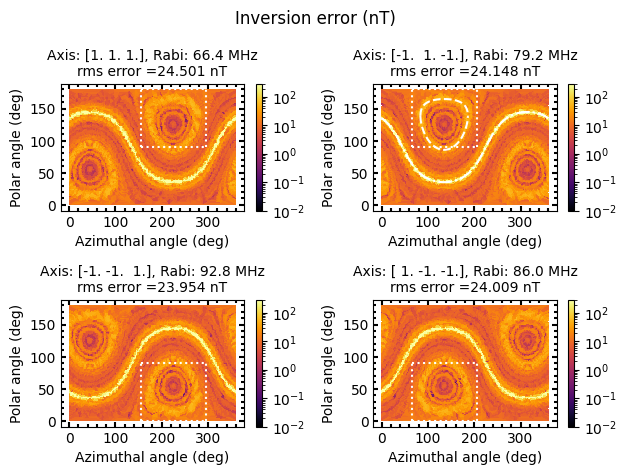

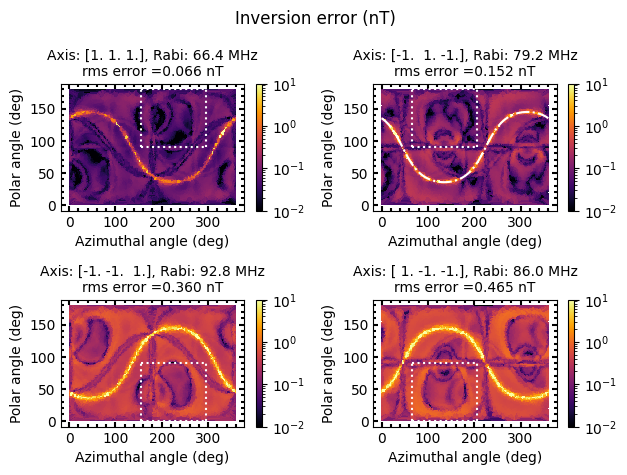

In [136]:
def half_hyperfine(theta, phi):
    return (-np.cos(theta)-np.cos(phi)*np.sin(theta) + np.sin(theta)*np.sin(phi))/np.sqrt(3) - f_h/(2*B_MAGNITUDE_T*gammab)

def get_rms_error_within_range( theta_range,phi_range, phi_values_total, theta_values_total, errors_vs_b_nT_total, orientation):
    masks = np.array([theta_values_total*360/(2*np.pi) < theta_range[1], theta_values_total*360/(2*np.pi) > theta_range[0], phi_values_total*360/(2*np.pi) < phi_range[1],phi_values_total*360/(2*np.pi) > phi_range[0]])
    mask = np.all(masks, axis=0)
    phi_values_masked = phi_values_total[mask]
    theta_values_masked = theta_values_total[mask]
    errors_vs_b_nT_masked = errors_vs_b_nT_total[mask]
    return np.sqrt(np.mean(errors_vs_b_nT_masked[:,orientation]**2))

def plot_errors_all_orientations(theta_values_total, phi_values_total, errors_vs_b_nT_total, plot_half_hyperfine=False, log_plot=True, vmin= 0.01, vmax=300):
    plotstyle = "log" if log_plot else "linear"

    theta_hh_rad = np.array([fsolve(half_hyperfine, [2.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])
    theta_hh_rad_low = np.array([fsolve(half_hyperfine, [1.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])
    
    theta_ranges = [[90,180],[90,180],[0,90],[0,90]]
    phi_ranges = [[155, 295], [155-90, 295-90],[155, 295], [155-90, 295-90]]

    for i,EXAMPLE_ORIENTATION in enumerate(NVOrientation):
        plt.subplot(2,2,i+1)
        plt.tripcolor(np.array(phi_values_total)*RAD_TO_DEGREE, np.array(theta_values_total)*RAD_TO_DEGREE, np.abs(np.array(errors_vs_b_nT_total)[:,EXAMPLE_ORIENTATION]),cmap="inferno", norm=plotstyle, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.xlabel("Azimuthal angle (deg)")
        plt.ylabel("Polar angle (deg)")
        plt.gca().yaxis.set_ticks_position("both")
        plt.gca().xaxis.set_ticks_position("both")
        plt.gca().minorticks_on()
        plt.gca().tick_params(direction="in", which = "both", width=1.5)
        plt.gca().tick_params(direction="in", which = "minor", length=2)
        plt.gca().tick_params(direction="in", which = "major", length=3.5)
        rms_error = get_rms_error_within_range(theta_ranges[i], phi_ranges[i], np.array(phi_values_total), np.array(theta_values_total), np.array(errors_vs_b_nT_total), i)
        plt.title(
            f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[EXAMPLE_ORIENTATION], precision=0)}, Rabi: {rabi_frequencies[EXAMPLE_ORIENTATION] * 1e-6:.1f} MHz\nrms error ={rms_error:.3f} nT", fontsize=10
        )
        plt.vlines(phi_ranges[i], [theta_ranges[i][0]],[theta_ranges[i][1]], linestyle="dotted", color="white")
        plt.hlines(theta_ranges[i], [phi_ranges[i][0]], [phi_ranges[i][1]], linestyle="dotted", color="white")

        if i==1:
            phi_range_full = np.linspace(0, 2*np.pi, 101)
            theta_no_projection = np.atan2(1, np.sin(phi_range_full) - np.cos(phi_range_full))
            plt.plot(phi_range_full*RAD_TO_DEGREE, theta_no_projection * RAD_TO_DEGREE, color="white", linestyle="dashdot")

            if plot_half_hyperfine:
                plt.plot(PHI_RANGE_HALF_HYPERFINE*RAD_TO_DEGREE, theta_hh_rad*RAD_TO_DEGREE, color="white", linestyle="dashed")
                plt.plot(PHI_RANGE_HALF_HYPERFINE*RAD_TO_DEGREE, theta_hh_rad_low*RAD_TO_DEGREE, color="white", linestyle="dashed")

    plt.suptitle("Inversion error (nT)")
    plt.tight_layout()
    plt.show()

base_path = "/Users/lilianchildress/Documents/GitHub/sbq-dq-simulator/"
RUN_LABEL = f"b_{B_MAGNITUDE_T*T_TO_UT:.0f}_ut_t2s_{T2STAR_S*1e6:.0f}_us_fine_3us_ramsey_800ns_rabi"
errors_vs_b_freq_domain_nT = list(np.loadtxt(base_path+f"errors_nt_freq_{RUN_LABEL}.txt"))
errors_vs_b_time_domain_nT = list(np.loadtxt(base_path+f"errors_nt_time_{RUN_LABEL}.txt", ))
phi_values = list(np.loadtxt(base_path+f"phi_values_{RUN_LABEL}.txt"))
theta_values = list(np.loadtxt(base_path+f"theta_values_{RUN_LABEL}.txt"))
plot_errors_all_orientations(theta_values, phi_values, errors_vs_b_freq_domain_nT, True)
plot_errors_all_orientations(theta_values, phi_values, errors_vs_b_time_domain_nT, False, True, vmin=0.01, vmax=10)





In [125]:
print(np.sqrt(np.mean(np.array(errors_vs_b_freq_domain_nT)**2)))
print(np.sqrt(np.mean(np.array(errors_vs_b_time_domain_nT)**2)))

85.54894053717275
4.901344581823399


In [ ]:
theta_values_total = np.array(theta_values)
phi_values_total = np.array(phi_values)
errors_vs_b_nT_total = np.array(errors_vs_b_time_domain_nT)

def get_rms_error_within_range( theta_range,phi_range, phi_values_total, theta_values_total, errors_vs_b_nT_total, orientation):
    masks = np.array([theta_values_total*360/(2*np.pi) < theta_range[1], theta_values_total*360/(2*np.pi) > theta_range[0], phi_values_total*360/(2*np.pi) < phi_range[1],phi_values_total*360/(2*np.pi) > phi_range[0]])
    mask = np.all(masks, axis=0)
    phi_values_masked = phi_values_total[mask]
    theta_values_masked = theta_values_total[mask]
    errors_vs_b_nT_masked = errors_vs_b_nT_total[mask]
    return np.sqrt(np.mean(errors_vs_b_nT_masked[:,orientation]**2))

theta_ranges = [[90,180],[90,180],[0,90],[0,90]]
phi_ranges = [[155, 295], [155-90, 295-90],[155, 295], [155-90, 295-90]]


get_rms_error_within_range([90,180], [155, 295], np.array(phi_values), np.array(theta_values), np.array(errors_vs_b_time_domain_nT), 0)


np.float64(0.06576299623734079)

In [93]:
MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  # np.linspace(0, 0.5e-6, 1001)
EVOLUTION_TIME_S = np.arange(0, 3e-6, 10e-9)  # p.linspace(0, 15e-6, 801)
len(MW_PULSE_LENGTH_S)*len(EVOLUTION_TIME_S)*10e-6

0.48000000000000004

In [139]:
print(list(rabi_frequencies))

[np.float64(66364423.69292802), np.float64(79174946.48739058), np.float64(92756072.06279232), np.float64(85965509.82093404)]


/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_93460/1075004786.py:18: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad = np.array([fsolve(half_hyperfine, [2.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])
/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_93460/1075004786.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  theta_hh_rad_low = np.array([fsolve(half_hyperfine, [1.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])


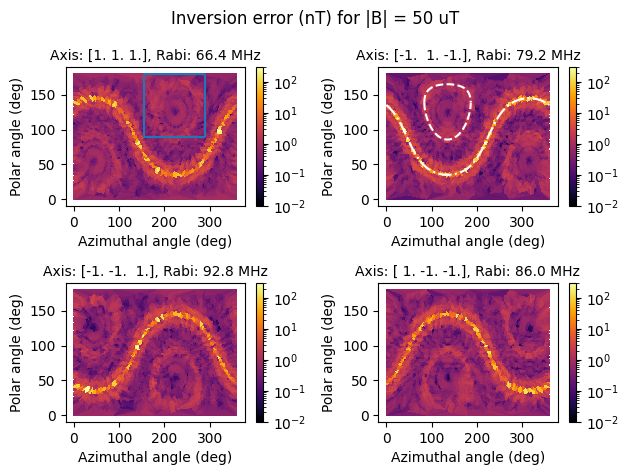

In [142]:
# Plot data on accuracy at 50 uT. Generated over several runs using simulate_and_invert_vs_b_angle.py" with the following settings:
# MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) 
# E_FIELD_VECTOR_V_PER_CM = 0 * np.array([1e5, 3e5, 0]) / exy
# B_MAGNITUDE_T = 50e-6
# RABI_FREQ_BASE_HZ = 100e6
# DETUNING_HZ = 0e6
# MW_PULSE_LENGTH_S = np.arange(0, 400e-9, 2.5e-9)  
# EVOLUTION_TIME_S = np.arange(0, 5e-6, 20e-9) 
# T2STAR_S = 2e-6
# N_RAMSEY_POINTS = 251
# RAMSEY_FREQ_RANGE_INITIAL_GUESS_HZ = np.linspace(0, 10e6, N_RAMSEY_POINTS)
# In InnerProductSettings:  rabi_window="blackman", ramsey_window="boxcar", subtract_mean=True, use_effective_rabi_frequency=True
# In double_cosine_inner_product_inversion: constrain_same_width=True, allow_zero_peak=True

def half_hyperfine(theta, phi):
    return (-np.cos(theta)-np.cos(phi)*np.sin(theta) + np.sin(theta)*np.sin(phi))/np.sqrt(3) - f_h/(2*B_MAGNITUDE_T*gammab)

theta_hh_rad = np.array([fsolve(half_hyperfine, [2.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])
theta_hh_rad_low = np.array([fsolve(half_hyperfine, [1.5], (phi))[0] for phi in PHI_RANGE_HALF_HYPERFINE])

base_path = "/Users/lilianchildress/Documents/GitHub/sbq-dq-simulator/bff_paper_figures/scratchwork/"

#errors_vs_b_nT=np.loadtxt(base_path+"errors_vs_b_nt.txt")
#phi_values=np.loadtxt(base_path+"phi_values.txt")
#theta_values=np.loadtxt(base_path+"theta_values.txt")

errors_vs_b_nT_fine=np.loadtxt(base_path+"errors_nt_b_50_ut_t2s_2.000000_us.txt")
phi_values_fine=np.loadtxt(base_path+"phi_values_b_50_ut_t2s_2.000000_us.txt")
theta_values_fine=np.loadtxt(base_path+"theta_values_b_50_ut_t2s_2.000000_us.txt")

errors_vs_b_nT_fine2=np.loadtxt(base_path+"errors_nt_b_50_ut_t2s_2.000000_us_interleaved.txt")
phi_values_fine2=np.loadtxt(base_path+"phi_values_b_50_ut_t2s_2.000000_us_interleaved.txt")
theta_values_fine2=np.loadtxt(base_path+"theta_values_b_50_ut_t2s_2.000000_us_interleaved.txt")

errors_vs_b_nT_total=np.concatenate((errors_vs_b_nT_fine,errors_vs_b_nT_fine2))
phi_values_total = np.concatenate((phi_values_fine,phi_values_fine2))
theta_values_total = np.concatenate((theta_values_fine,theta_values_fine2))

for i,EXAMPLE_ORIENTATION in enumerate(NVOrientation):
    plt.subplot(2,2,i+1)
    plt.tripcolor(np.array(phi_values_total)*RAD_TO_DEGREE, np.array(theta_values_total)*RAD_TO_DEGREE, np.abs(np.array(errors_vs_b_nT_total)[:,EXAMPLE_ORIENTATION]),cmap="inferno", norm="log", vmin=.01, vmax=300)
    plt.colorbar()
    plt.xlabel("Azimuthal angle (deg)")
    plt.ylabel("Polar angle (deg)")
    plt.title(
        f"Axis: {np.array2string(np.sqrt(3) * NVaxes_100[EXAMPLE_ORIENTATION], precision=0)}, Rabi: {rabi_frequencies[EXAMPLE_ORIENTATION] * 1e-6:.1f} MHz", fontsize=10
    )
    if i==0:
        plt.vlines([155, 290], [90], [180])
        plt.hlines([90, 180],[155], [290])
    if i==1:
        phi_range_full = np.linspace(0, 2*np.pi, 101)
        theta_no_projection = np.atan2(1, np.sin(phi_range_full) - np.cos(phi_range_full))
        plt.plot(phi_range_full*RAD_TO_DEGREE, theta_no_projection * RAD_TO_DEGREE, color="white", linestyle="dashdot")

        plt.plot(PHI_RANGE_HALF_HYPERFINE*RAD_TO_DEGREE, theta_hh_rad*RAD_TO_DEGREE, color="white", linestyle="dashed")
        plt.plot(PHI_RANGE_HALF_HYPERFINE*RAD_TO_DEGREE, theta_hh_rad_low*RAD_TO_DEGREE, color="white", linestyle="dashed")

plt.suptitle("Inversion error (nT) for |B| = 50 uT")
plt.tight_layout()
plt.savefig(base_path+"accuracy50uT.svg")
plt.show()